This notebooks contains plots for the interpretability section of the paper, excluding the toy model subsection. For those, see the `empirics.ipynb` 
notebook.

1. Comparing latent factors vs. PCA
- Correlation matrix of F
- Cumulative log returns of the factors?

2. Cross-Sectional Loadings (Portfolio Loadings)
- 

3. Lag Loadings (Weight Decay) in Latent Factor Space
- Is there a trend in initial factors loading on short term and later factors loading on long term?
- Seasonality? 
- Show heatmaps for various K and lags
- Show the stability via generalized correlations line plots? 

4. Lag Loadings (Weight Decay) in Portfolio Space
- Which characteristics tend to load on which lags? Are they persistent, sinusoidal, etc?

In [1]:
import jax
import jax.numpy as jnp

import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, Tuple
from functools import partial
import pandas as pd
from collections import defaultdict
from tfm.parafac_jax import *
from tfm.parafac_admm import parafac_admm
from tfm.utils._tensor import *
from tfm.utils._pca import *
jax.config.update("jax_enable_x64", True)
os.environ['CUDA_VISIBLE_DEVICES'] = "1" # Titan and FP64 mode, 2 is V100?
jax.config.update('jax_platform_name', 'gpu')
print("JAX is using device:", jax.devices()[0], jax.devices())

start_date_oos = pd.to_datetime('2005-01-01')
window_size = 120
max_lag = 120
start = 'default'
max_horizon = 36
lst_K = [1, 2, 3, 4, 5, 10, 15, 20, 25]
lst_lags = [36, 60, 90, 120]

dataset = 'scs'
params = jnp.load(f'../organized_data/organized_data/{dataset}/dict_param_lag_120.pkl', allow_pickle=True)
bin_labels, all_dates = params['lst_char'], params['all_dates']
all_dates = all_dates[max_lag - 1:]
dates = all_dates[-len(all_dates[all_dates >= start_date_oos]) - window_size:] if start != 'default' else all_dates
trade_days = dates[window_size - 1: -max_horizon]

X = jnp.load(f'../organized_data/organized_data/{dataset}/mat_ptf_re_lag_120.npz')['mat_ptf_re_rank']
X_log = jnp.log(1 + X)

dir_in = f'../results_oos/multiperiod/{dataset}/tensor_fig_oos_ret_rankptf_ver4/'
dict_tensor_oos = jnp.load(dir_in + 'saved_dict_tensor_oos_1992.pkl', allow_pickle=True)

JAX is using device: cuda:0 [CudaDevice(id=0)]


# 1. Factors and Correlation

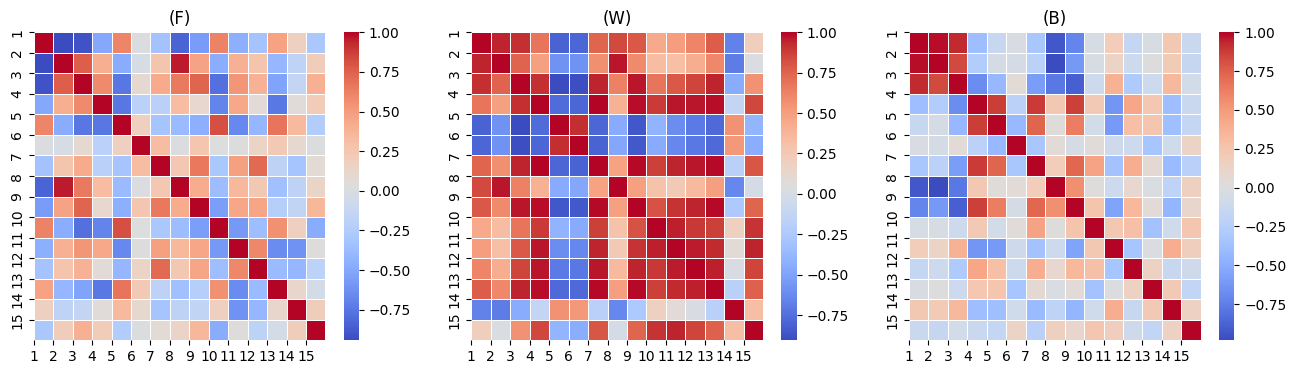

In [8]:
lag = 36
K = 15
weights, factors = parafac_enhanced(
    tensor=X_log[:, :lag, :],
    rank=K,
    random_state=random_seed,
    n_iter_max=n_iter_max,
    fix_intercept_mode=1,
)

# Extract and normalize factors
factors = dict(zip(['F','W','B'], factors))
factors['S'] = weights
factors = normalize_factors(factors, reorder=True)
F, W, B, S = [factors[key] for key in ['F','W','B','S']]

fig, axes = plt.subplots(1, 3, figsize=(16, 4))

ax = axes[0]
sns.heatmap(jnp.corrcoef(F.T), cmap='coolwarm', annot=False, fmt=".2f", linewidths=0.5, ax=ax)
ax.set_title("(F)")
ax.set_xticks(range(K))
ax.set_yticks(range(K))
ax.set_xticklabels(range(1, K+1))
ax.set_yticklabels(range(1, K+1))

ax = axes[1]
sns.heatmap(jnp.corrcoef(W.T), cmap='coolwarm', annot=False, fmt=".2f", linewidths=0.5, ax=ax)
ax.set_title("(W)")
ax.set_xticks(range(K))
ax.set_yticks(range(K))
ax.set_xticklabels(range(1, K+1))
ax.set_yticklabels(range(1, K+1))

ax = axes[2]
sns.heatmap(jnp.corrcoef(B.T), cmap='coolwarm', annot=False, fmt=".2f", linewidths=0.5, ax=ax)
ax.set_title("(B)")
ax.set_xticks(range(K))
ax.set_yticks(range(K))
ax.set_xticklabels(range(1, K+1))
ax.set_yticklabels(range(1, K+1))

plt.savefig("../interpretability/figures/corr.png")
plt.show()

In [24]:
for lag in lst_lags:
    for K in lst_K:

        weights, factors = parafac_enhanced(
            tensor=X_log[:, :lag, :],
            rank=K,
            n_iter_max=n_iter_max,
            fix_intercept_mode=1,
        )

        # Extract and normalize factors
        factors = dict(zip(['F','W','B'], factors))
        factors['S'] = weights
        factors = normalize_factors(factors, reorder=True)
        F, W, B, S = [factors[key] for key in ['F','W','B','S']]
        
        ### calc explained variance
        # error = calculate_reconstruction_error(X_log, S, [F, W, B])
        # print('K={}, Reconstruction Error: {:.3f} '.format(K, error))

        ### calc explained variance
        ev_reg=1-((X_log[:, :lag, :] - reconstruct_tensor(S, [F, W, B]))**2).sum() / (X_log[:, :lag, :]**2).sum()
        print(f'L={lag}, K={K}, Explained variation of X: {ev_reg:.3f} ')

L=36, K=1, Explained variation of X: 0.290 
L=36, K=2, Explained variation of X: 0.520 
L=36, K=3, Explained variation of X: 0.680 
L=36, K=4, Explained variation of X: 0.724 
L=36, K=5, Explained variation of X: 0.757 
L=36, K=10, Explained variation of X: 0.841 
L=36, K=15, Explained variation of X: 0.874 
L=36, K=20, Explained variation of X: 0.894 
L=36, K=25, Explained variation of X: 0.907 
L=60, K=1, Explained variation of X: 0.312 
L=60, K=2, Explained variation of X: 0.527 
L=60, K=3, Explained variation of X: 0.671 
L=60, K=4, Explained variation of X: 0.716 
L=60, K=5, Explained variation of X: 0.742 
L=60, K=10, Explained variation of X: 0.820 
L=60, K=15, Explained variation of X: 0.853 
L=60, K=20, Explained variation of X: 0.874 
L=60, K=25, Explained variation of X: 0.888 
L=90, K=1, Explained variation of X: 0.323 
L=90, K=2, Explained variation of X: 0.524 
L=90, K=3, Explained variation of X: 0.655 
L=90, K=4, Explained variation of X: 0.699 
L=90, K=5, Explained var

In [36]:
K = 25
T, L, N = X_log[:, :36, :].shape
orig = T * L * N
decomp = K * (T + L + N) + K
# reduces dimensionality by 97.5% while explaining 90.7% of the data
decomp, orig, 1 - decomp / orig

(13600, 547200, 0.9751461988304093)

# 2. Cross-Sectional Loadings

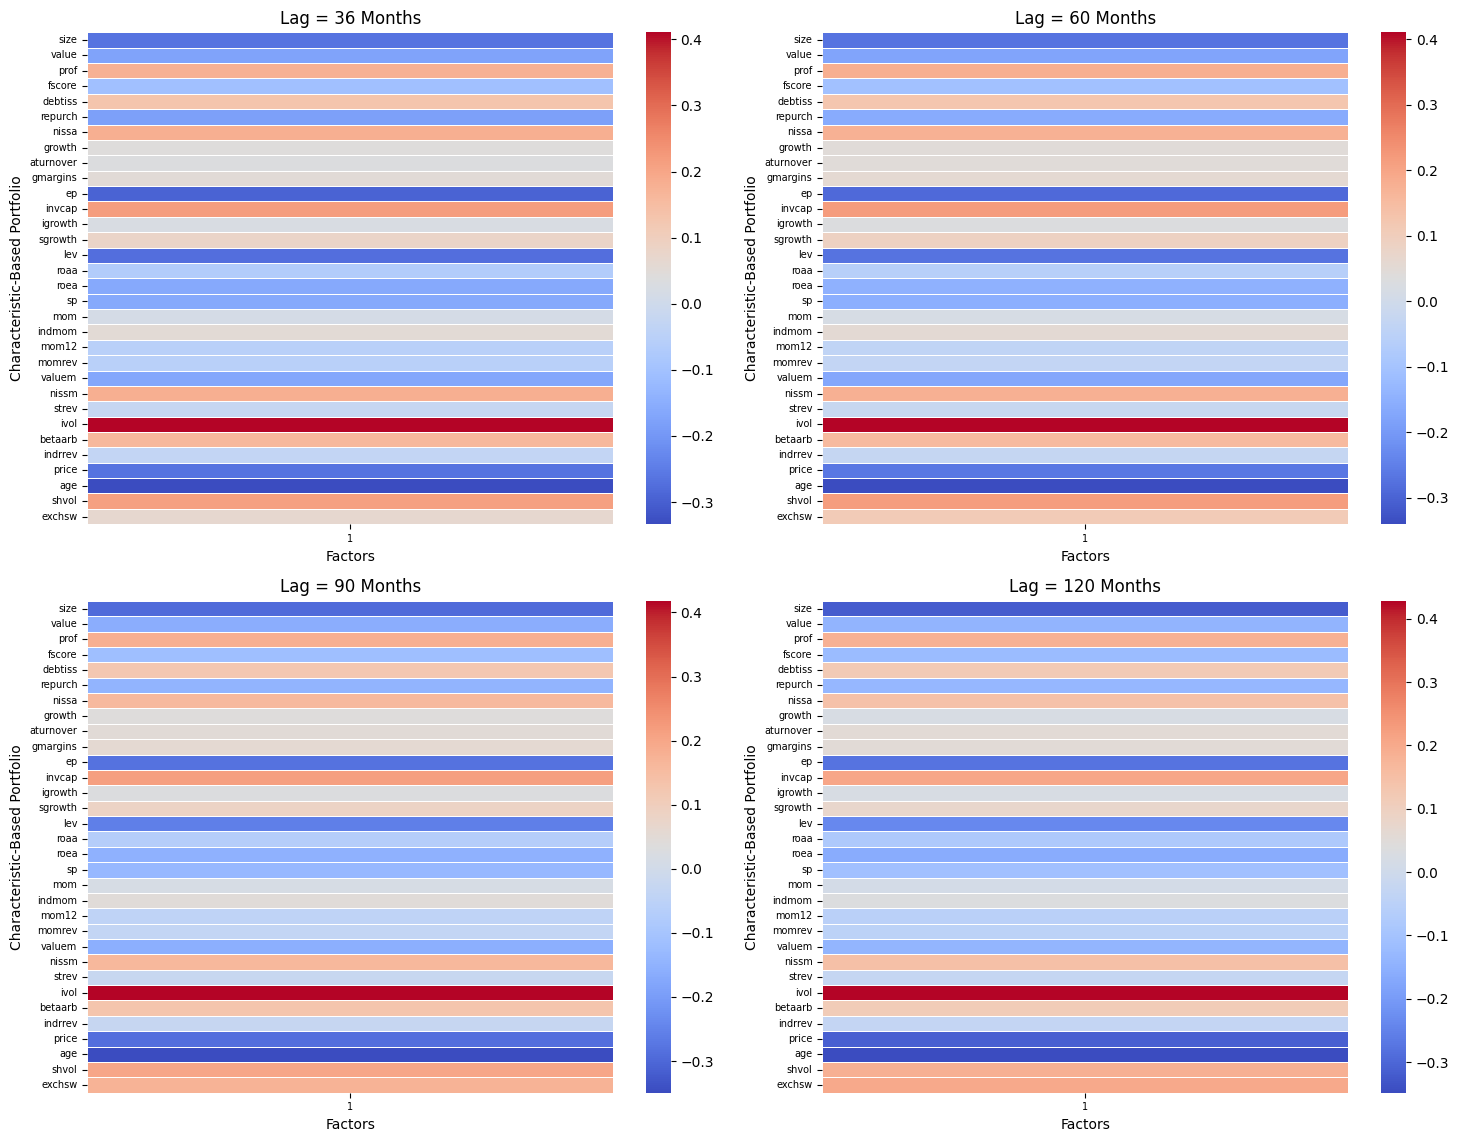

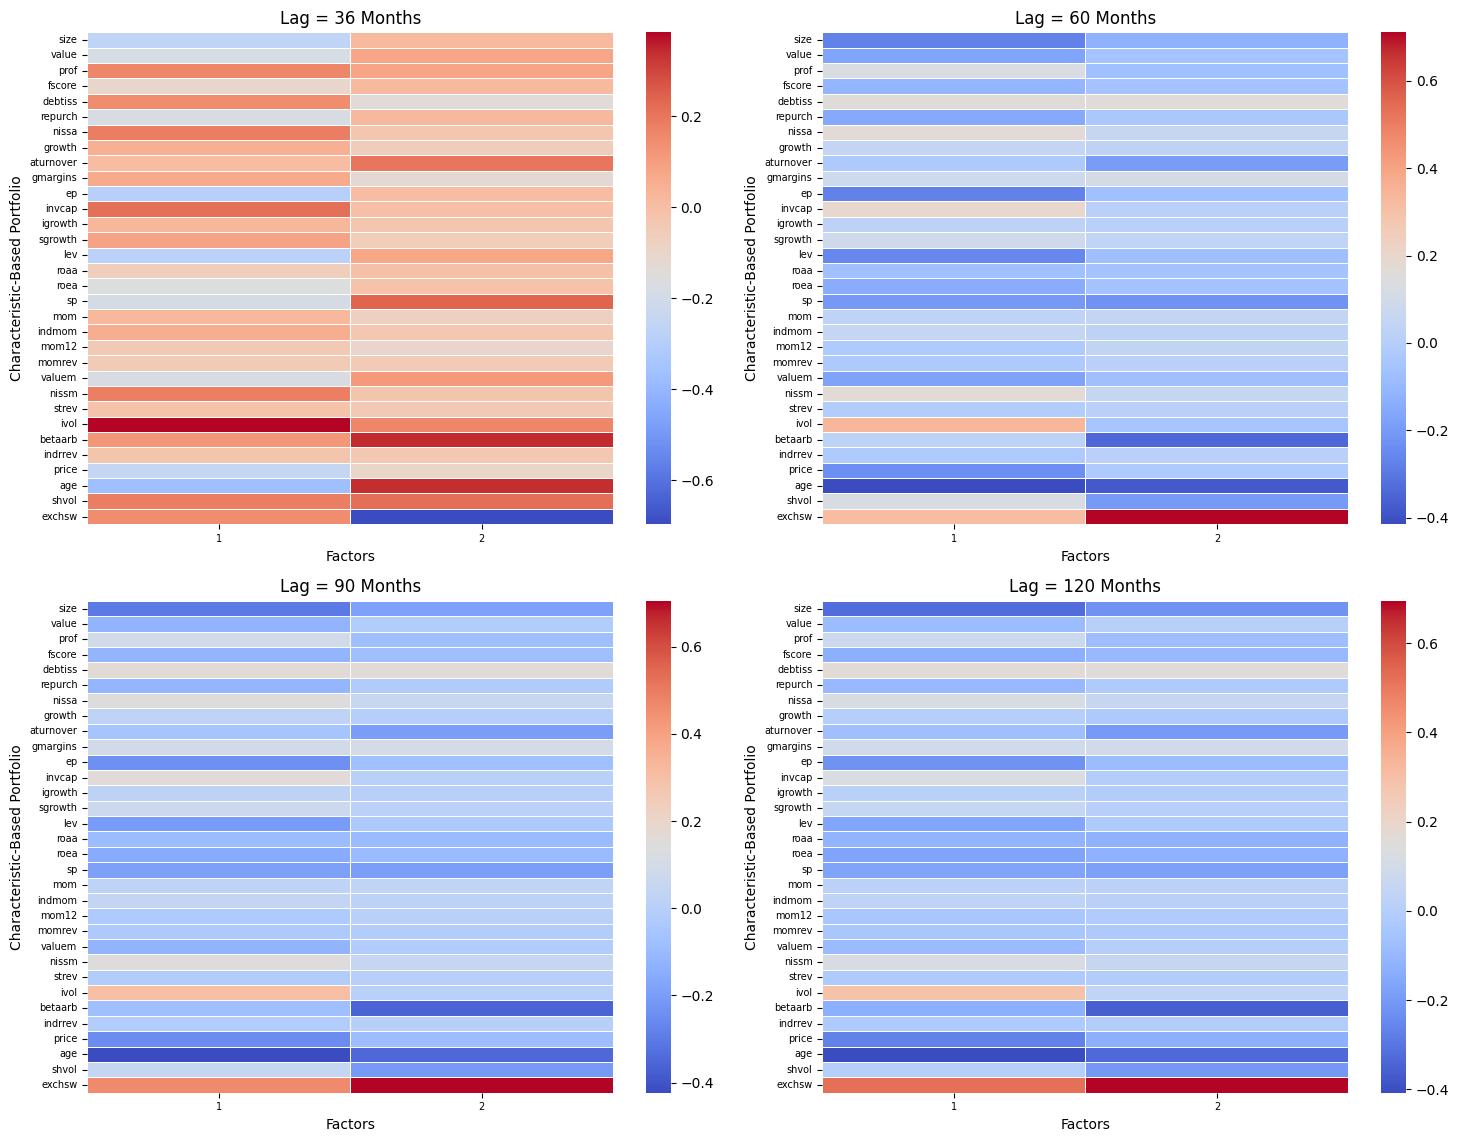

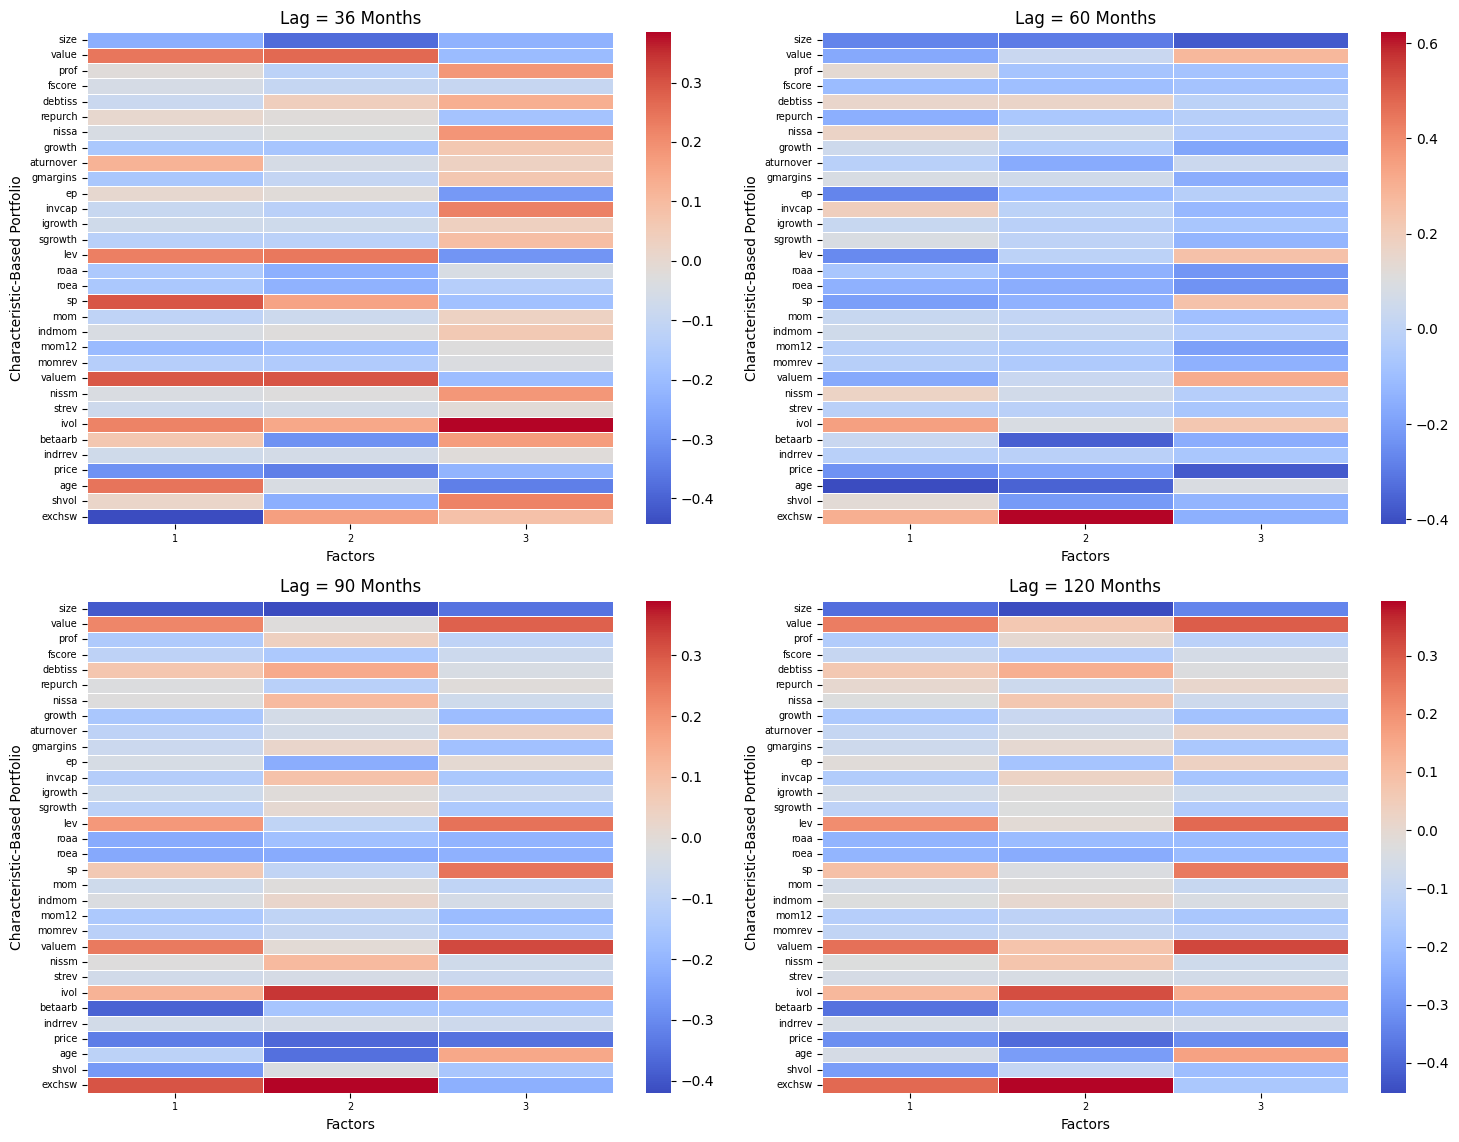

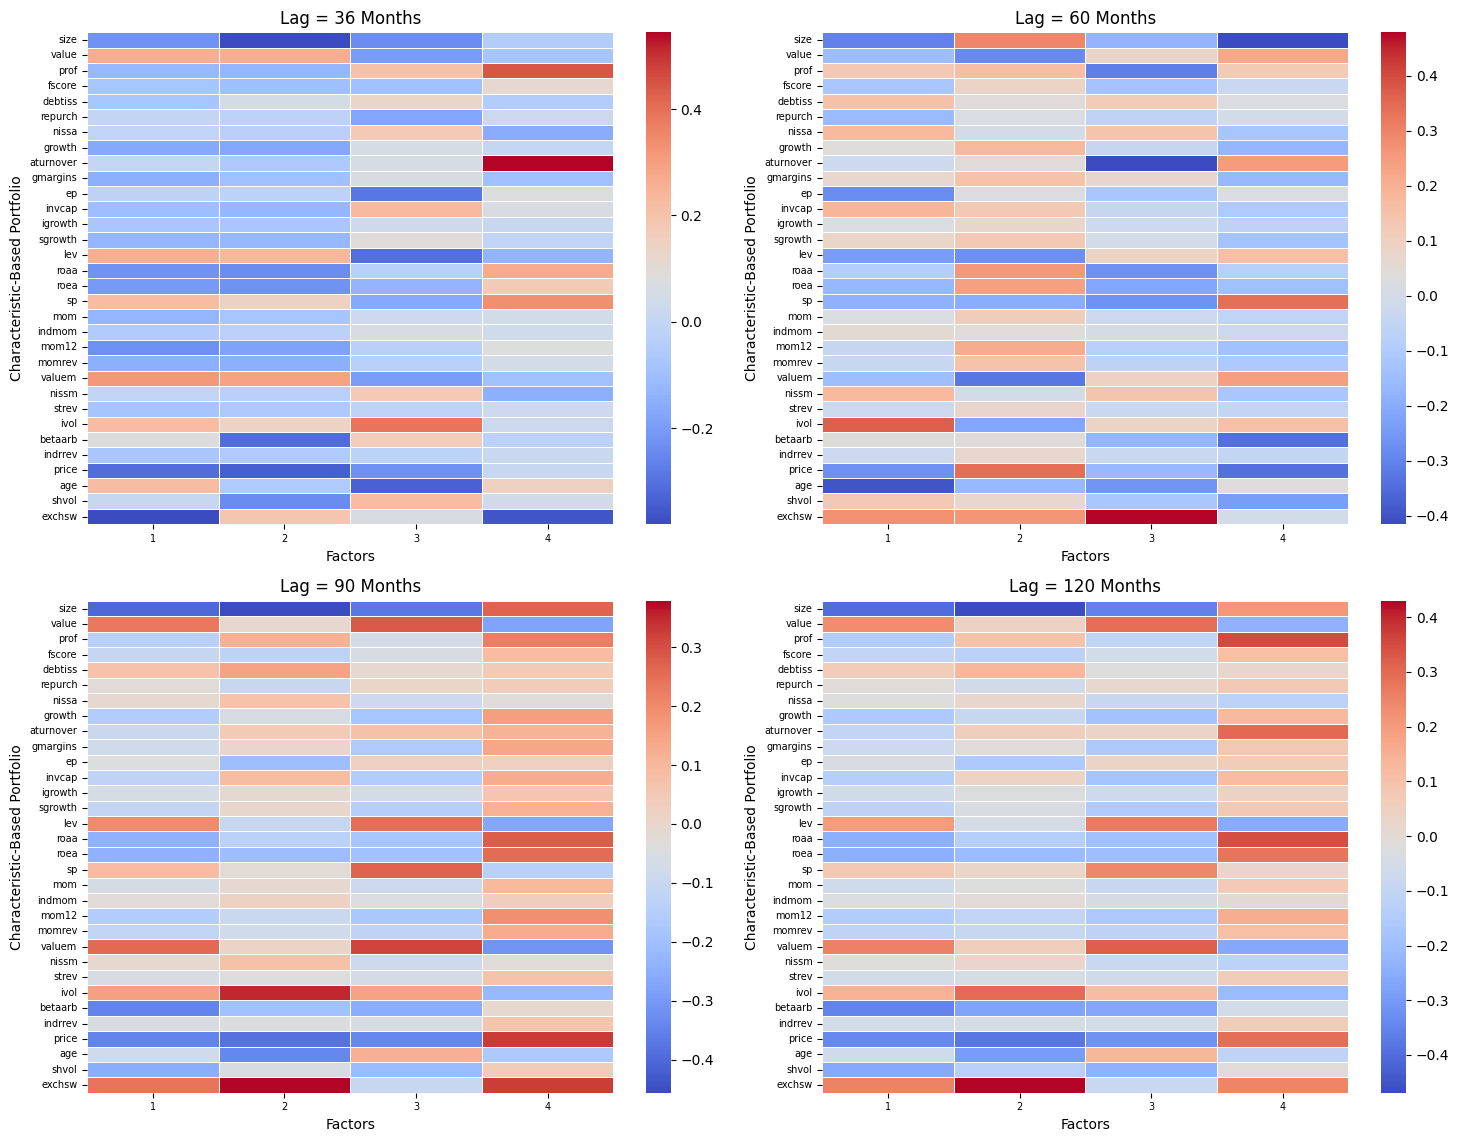

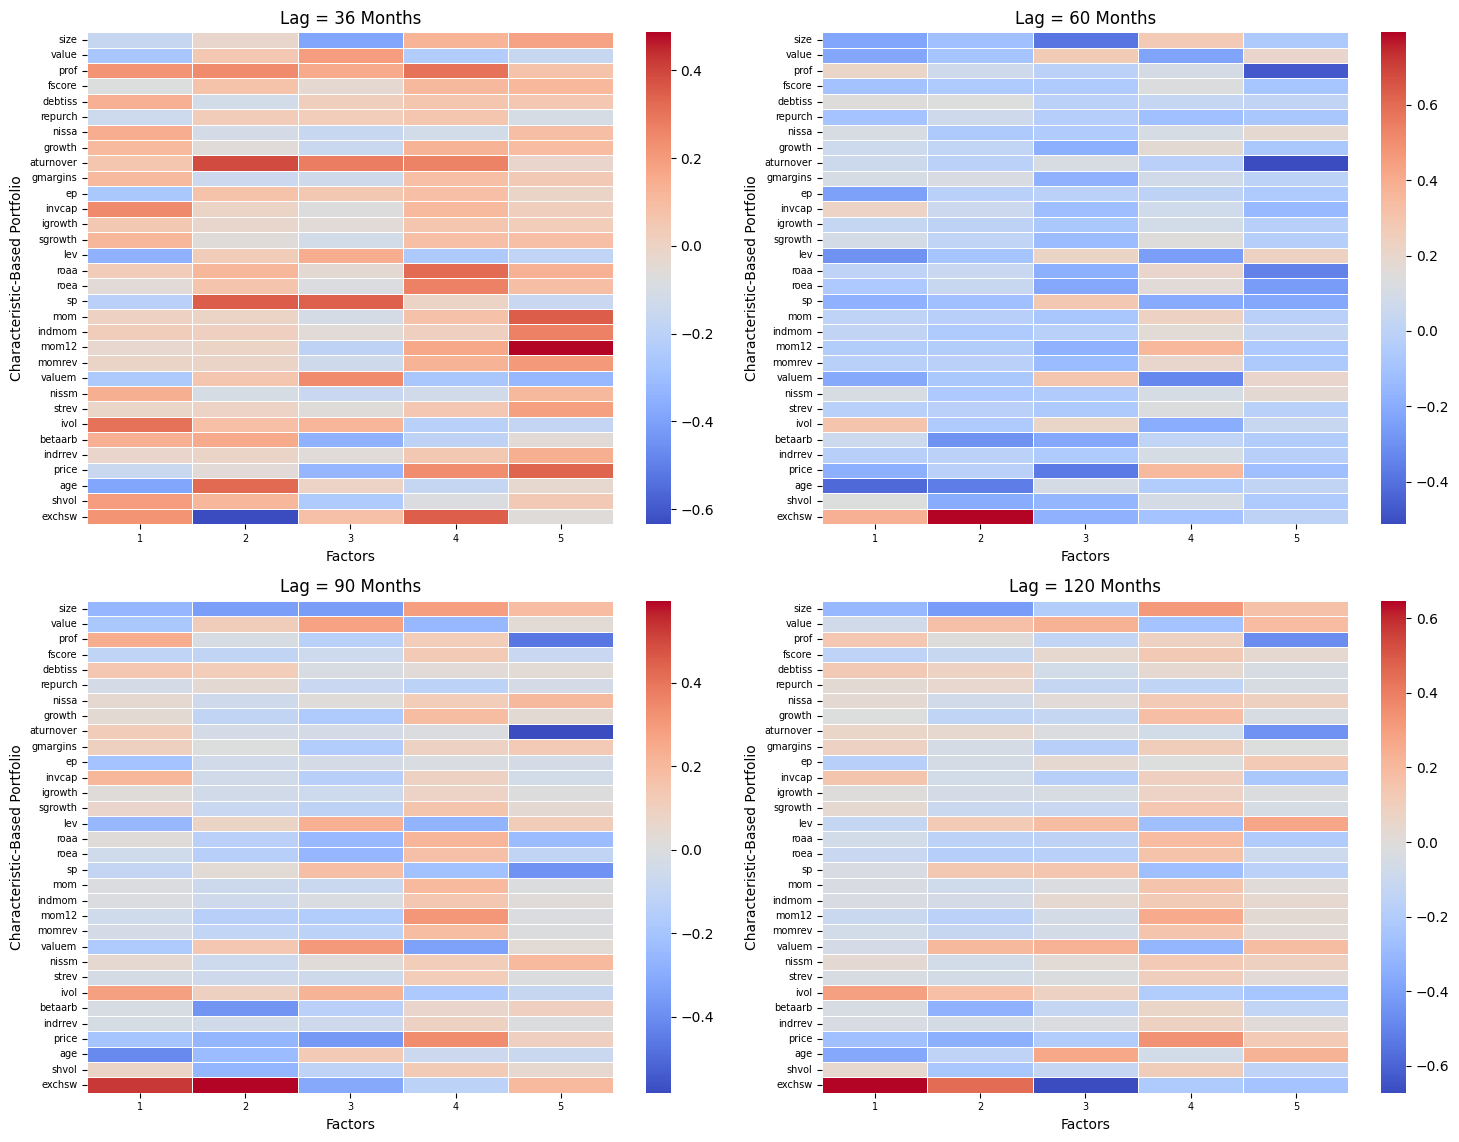

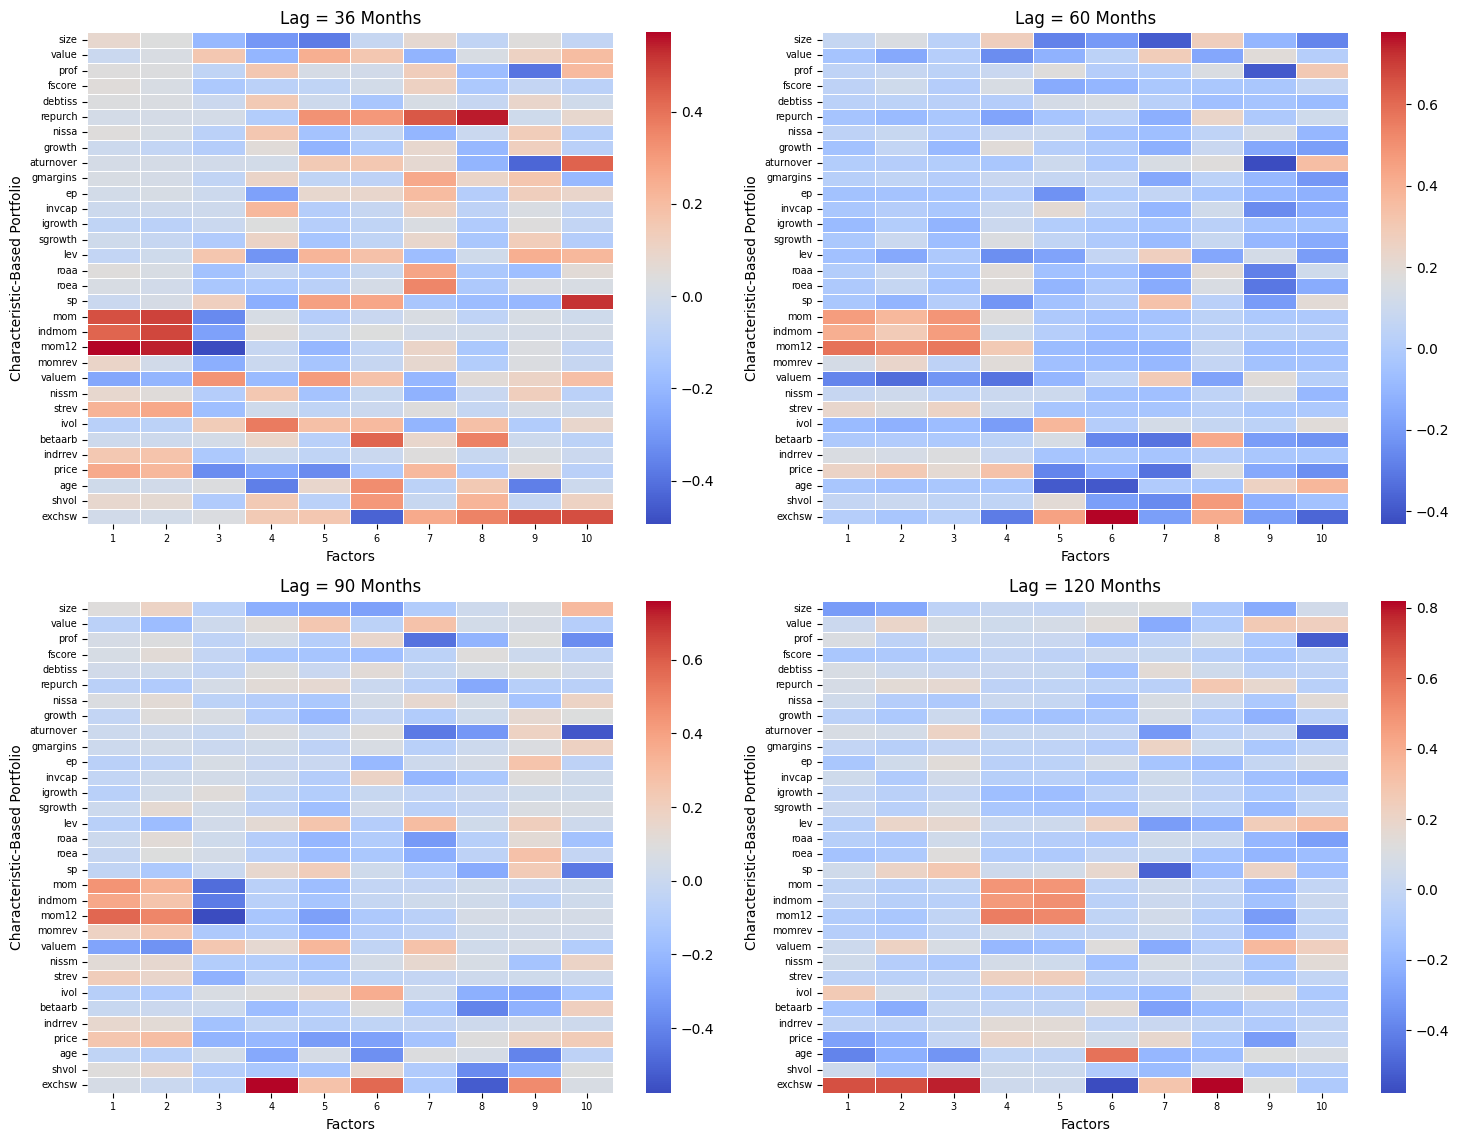

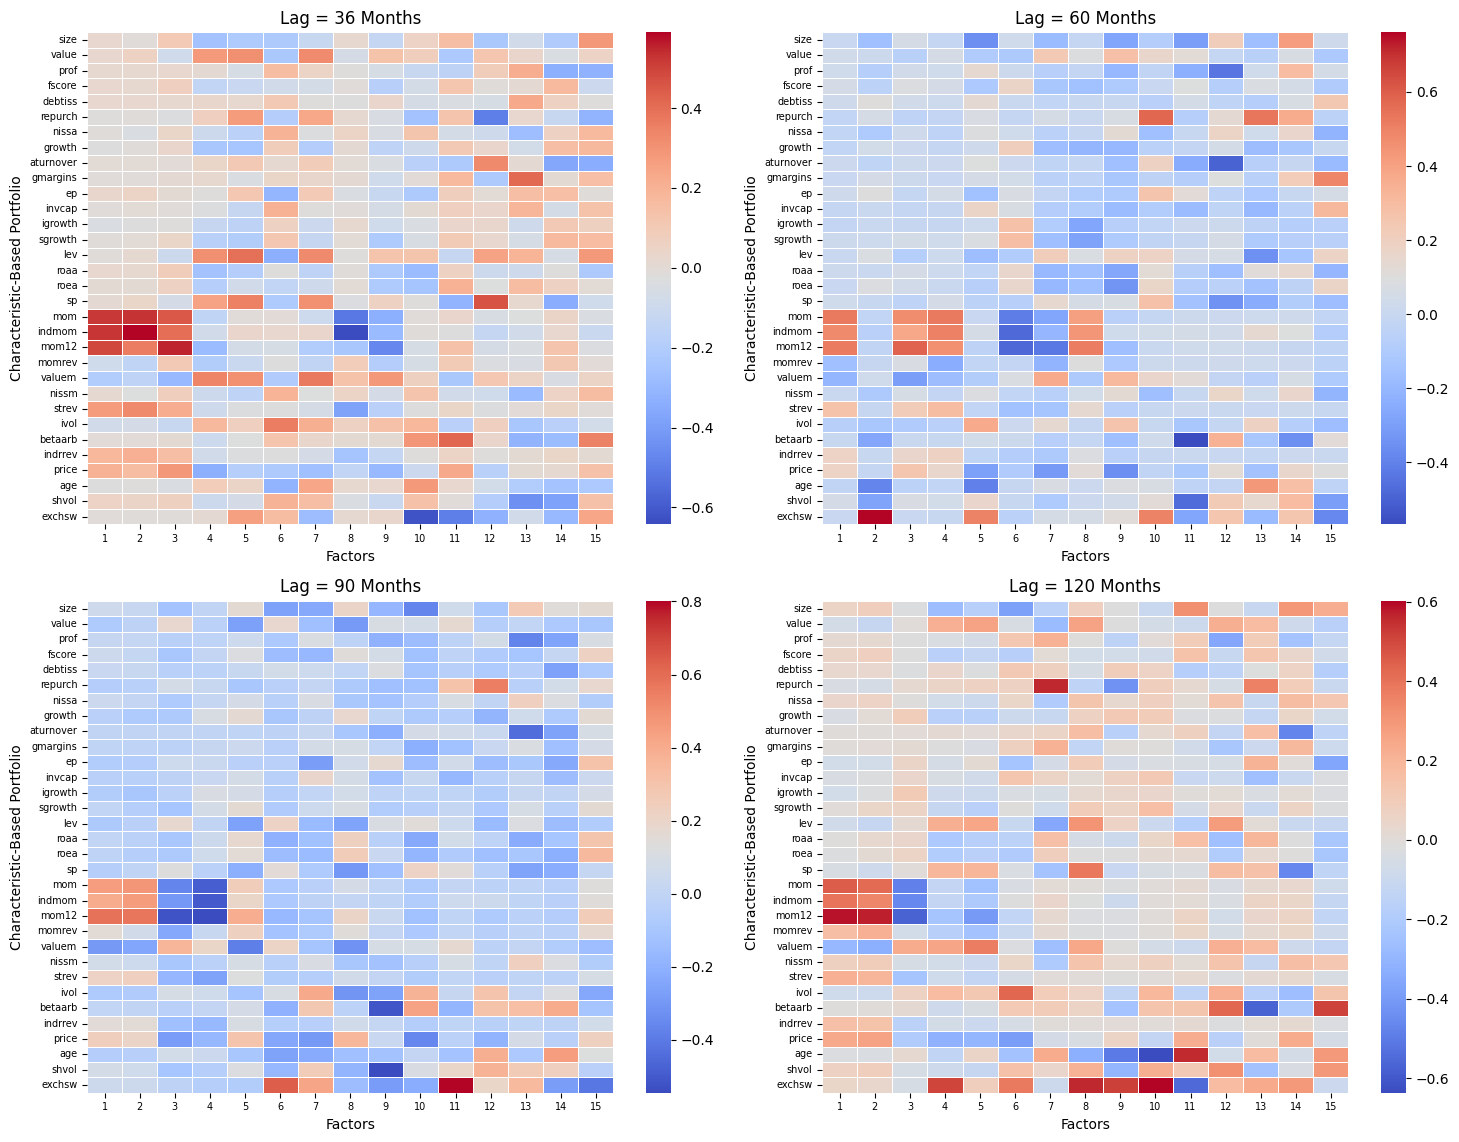

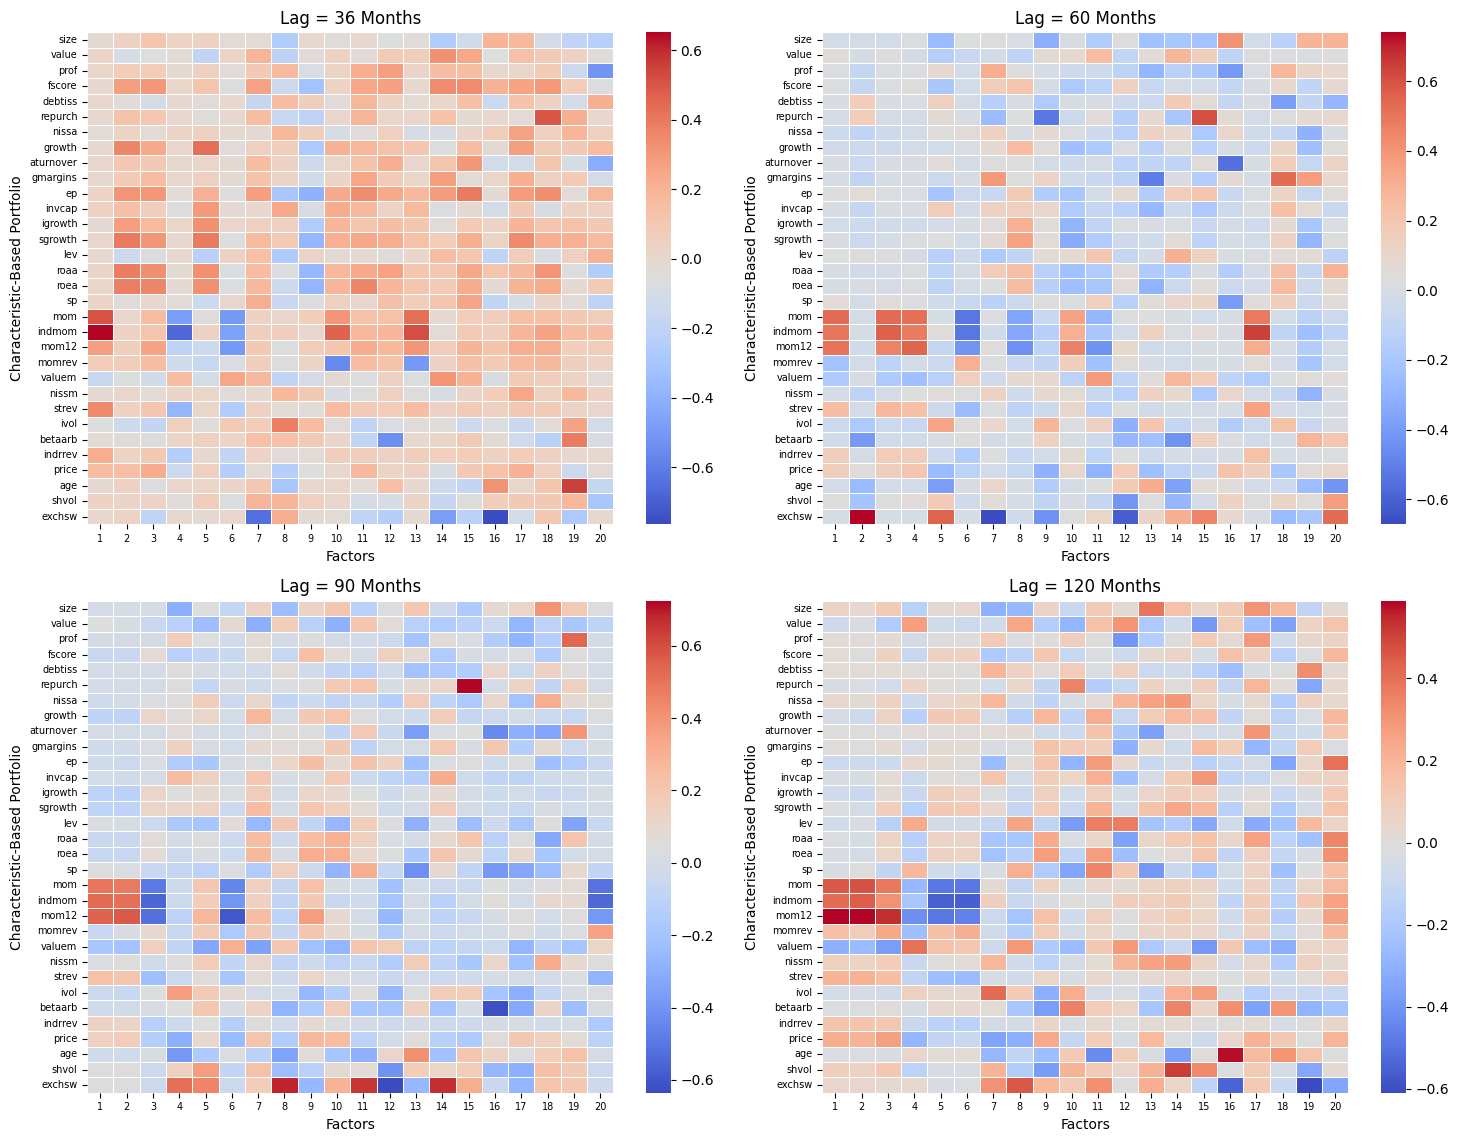

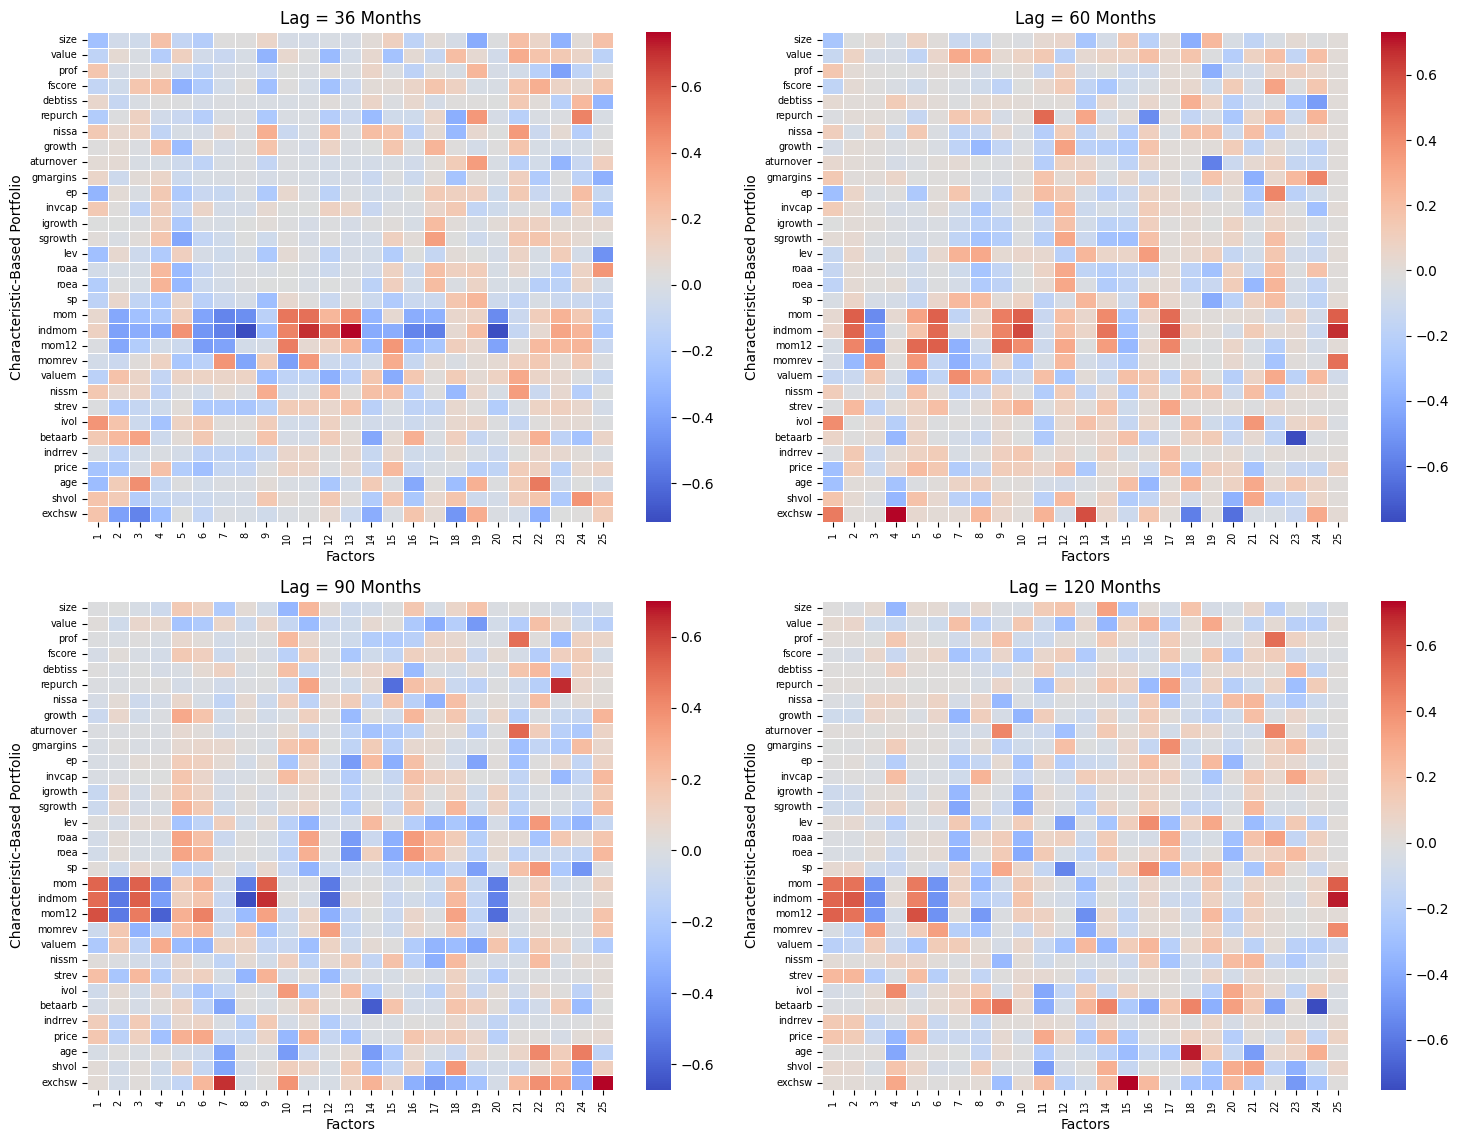

In [42]:
for K in lst_K:
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    # fig.suptitle(f"Cross-Sectional Loadings", fontsize=18)
    for idx, lag in enumerate(lst_lags):
        if idx >= 4:
            break
        
        weights, factors = parafac_enhanced(
            tensor=X_log[:, :lag, :],
            rank=K,
            random_state=random_seed,
            n_iter_max=n_iter_max,
            fix_intercept_mode=1,
        )

        # Extract and normalize factors
        factors = dict(zip(['F','W','B'], factors))
        factors['S'] = weights
        factors = normalize_factors(factors, reorder=True)
        F, W, B, S = [factors[key] for key in ['F','W','B','S']]

        ax = axes[idx // 2, idx % 2]
        sns.heatmap(B, cmap='coolwarm', annot=False, fmt=".2f", linewidths=0.5, 
                    yticklabels=bin_labels, ax=ax)
        
        ax.set_yticklabels(ax.get_yticklabels(), fontsize=7)  # Make yticklabels smalle
        ax.set_ylabel("Characteristic-Based Portfolio")
        ax.set_xticklabels(jnp.arange(K) + 1, fontsize=7)
        ax.set_xlabel("Factors")
        ax.set_title(f'Lag = {lag} Months', fontsize=12)

    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit main title
    plt.savefig(f'../interpretability/figures/B_{K}')
    plt.show()

# 3. Lag Loadings for Latent Factors

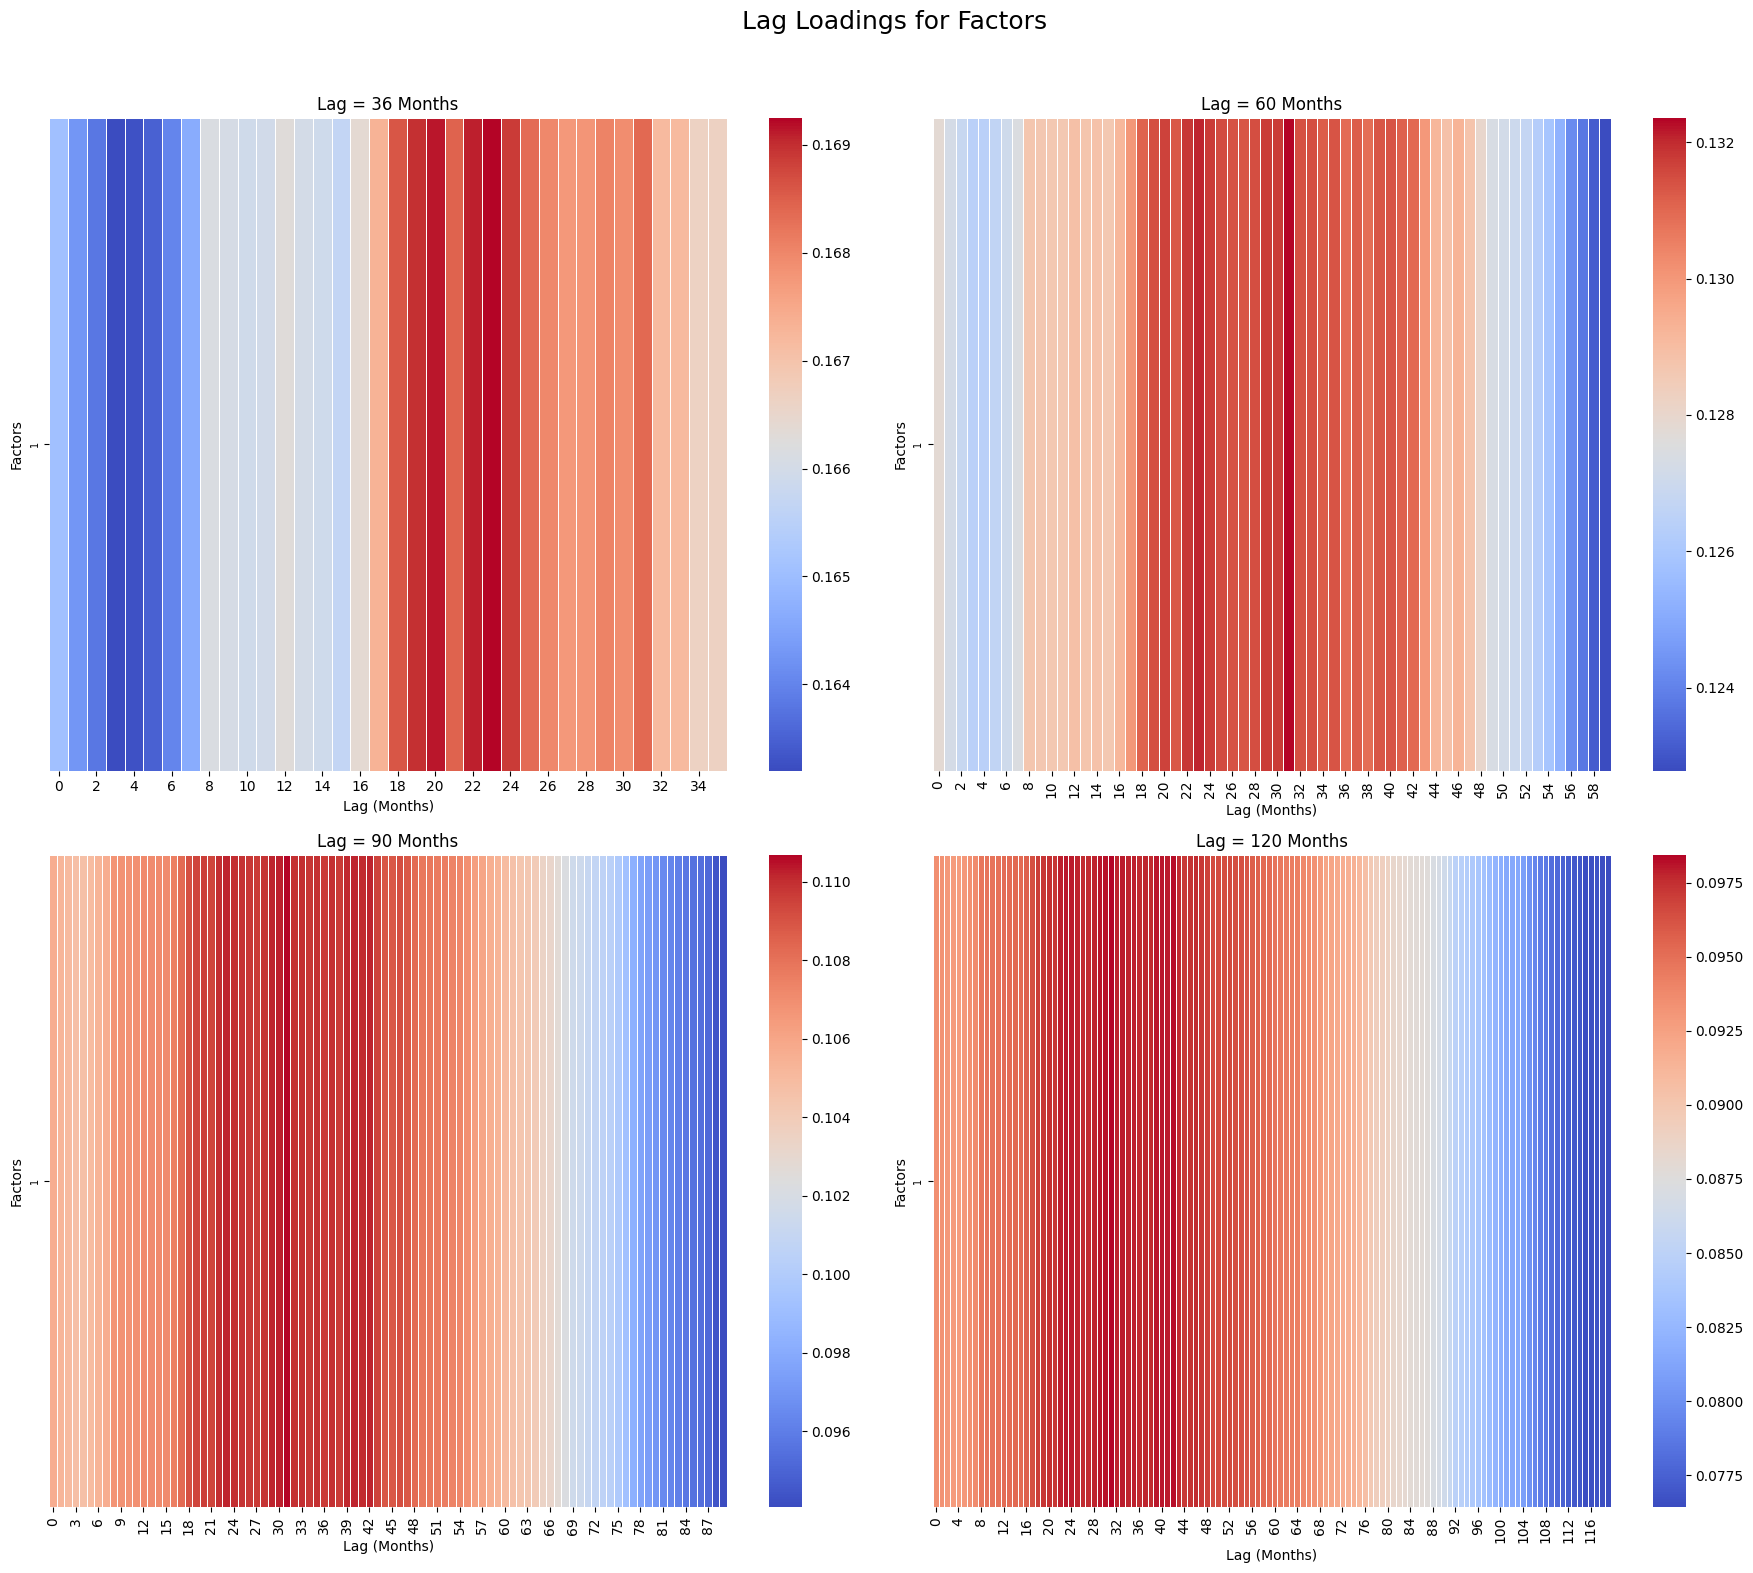

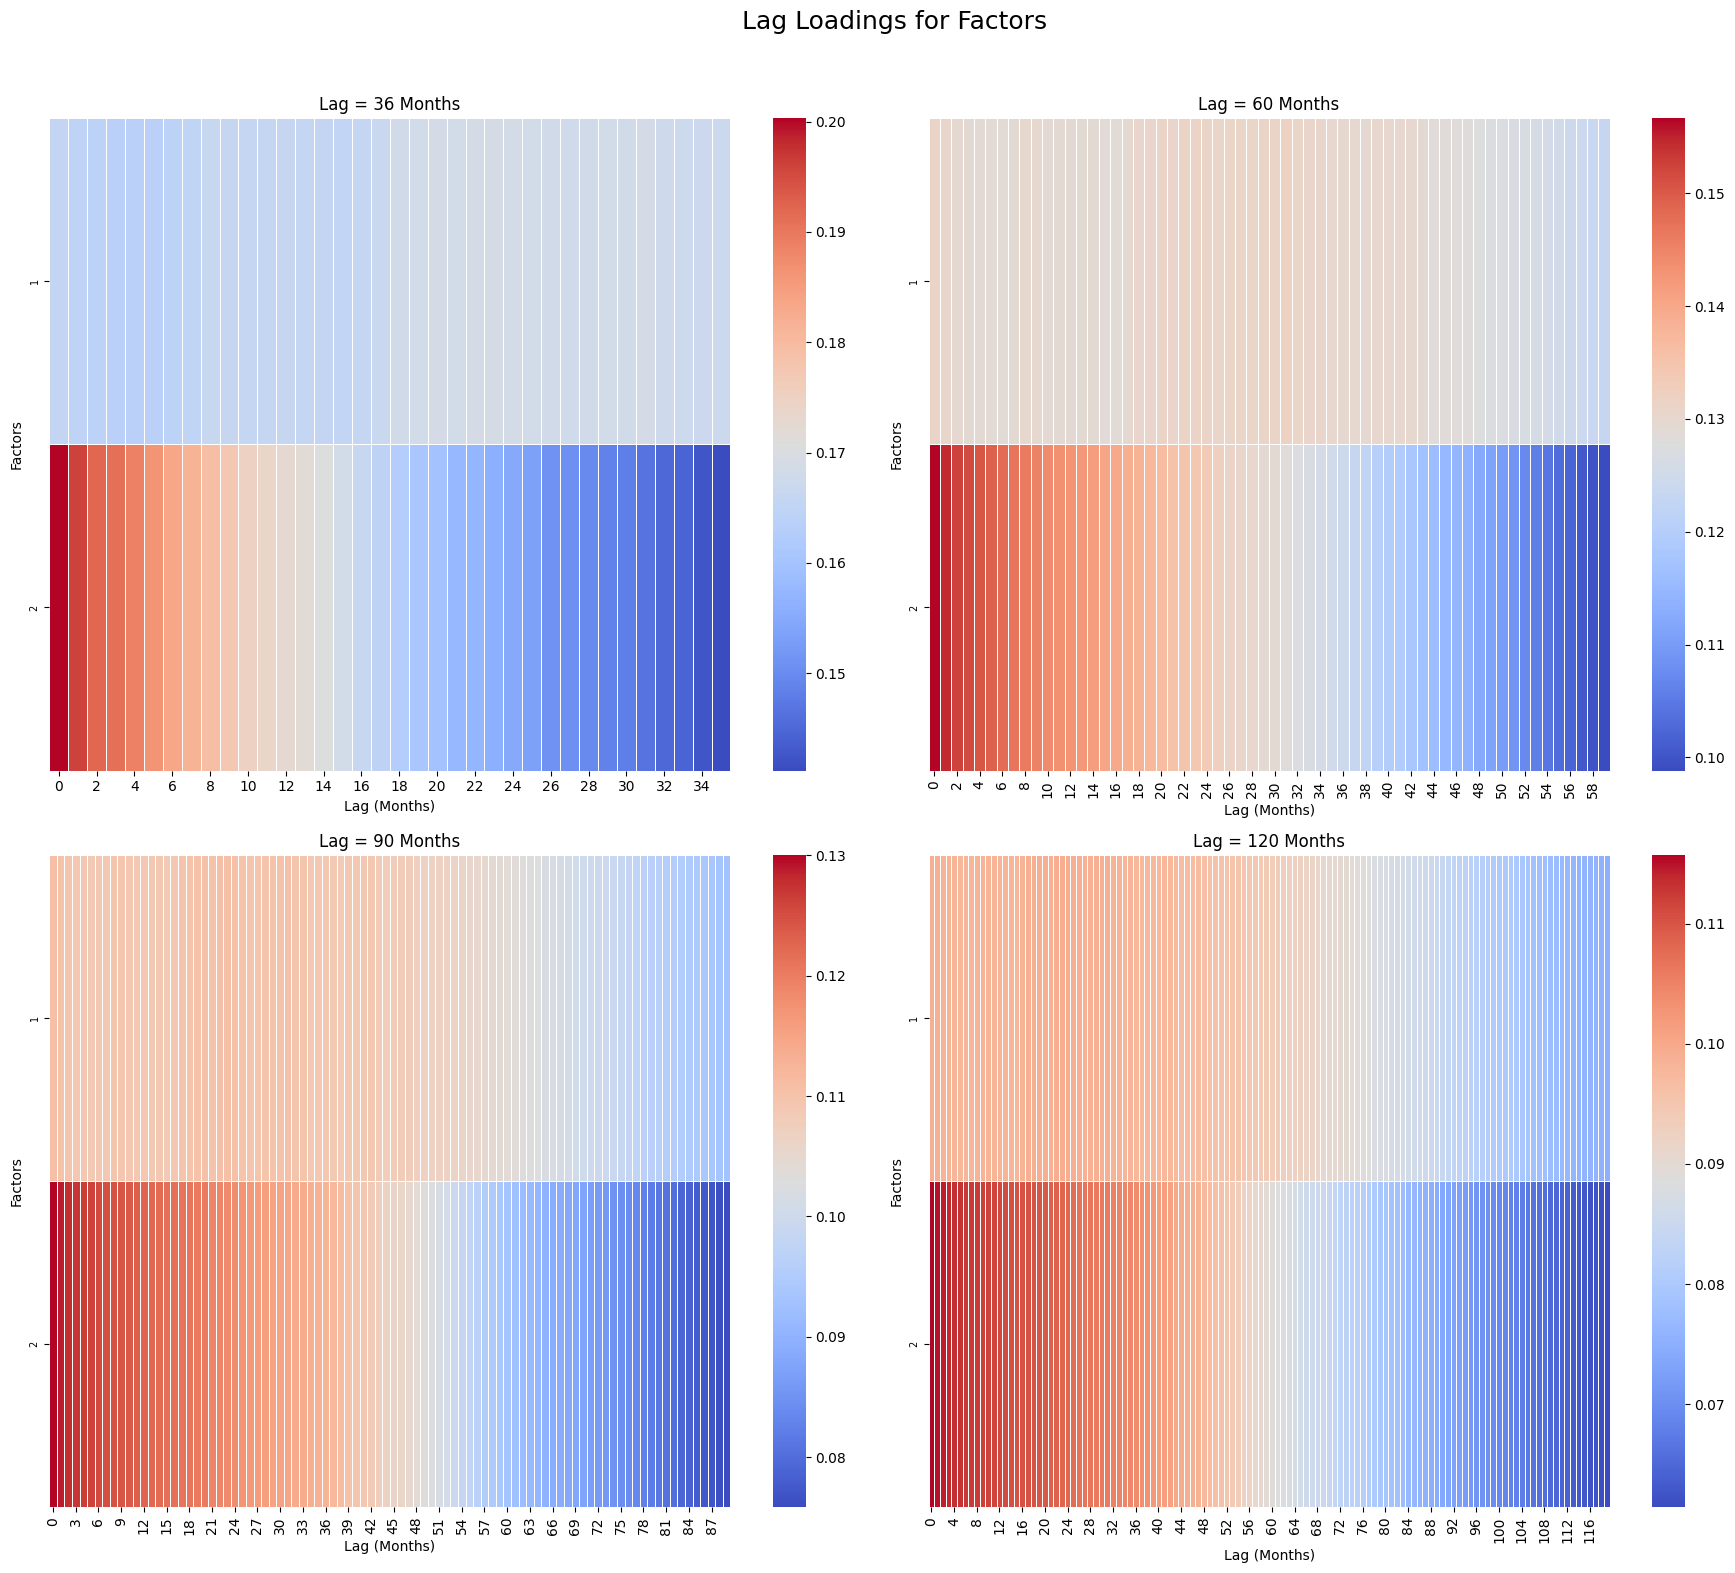

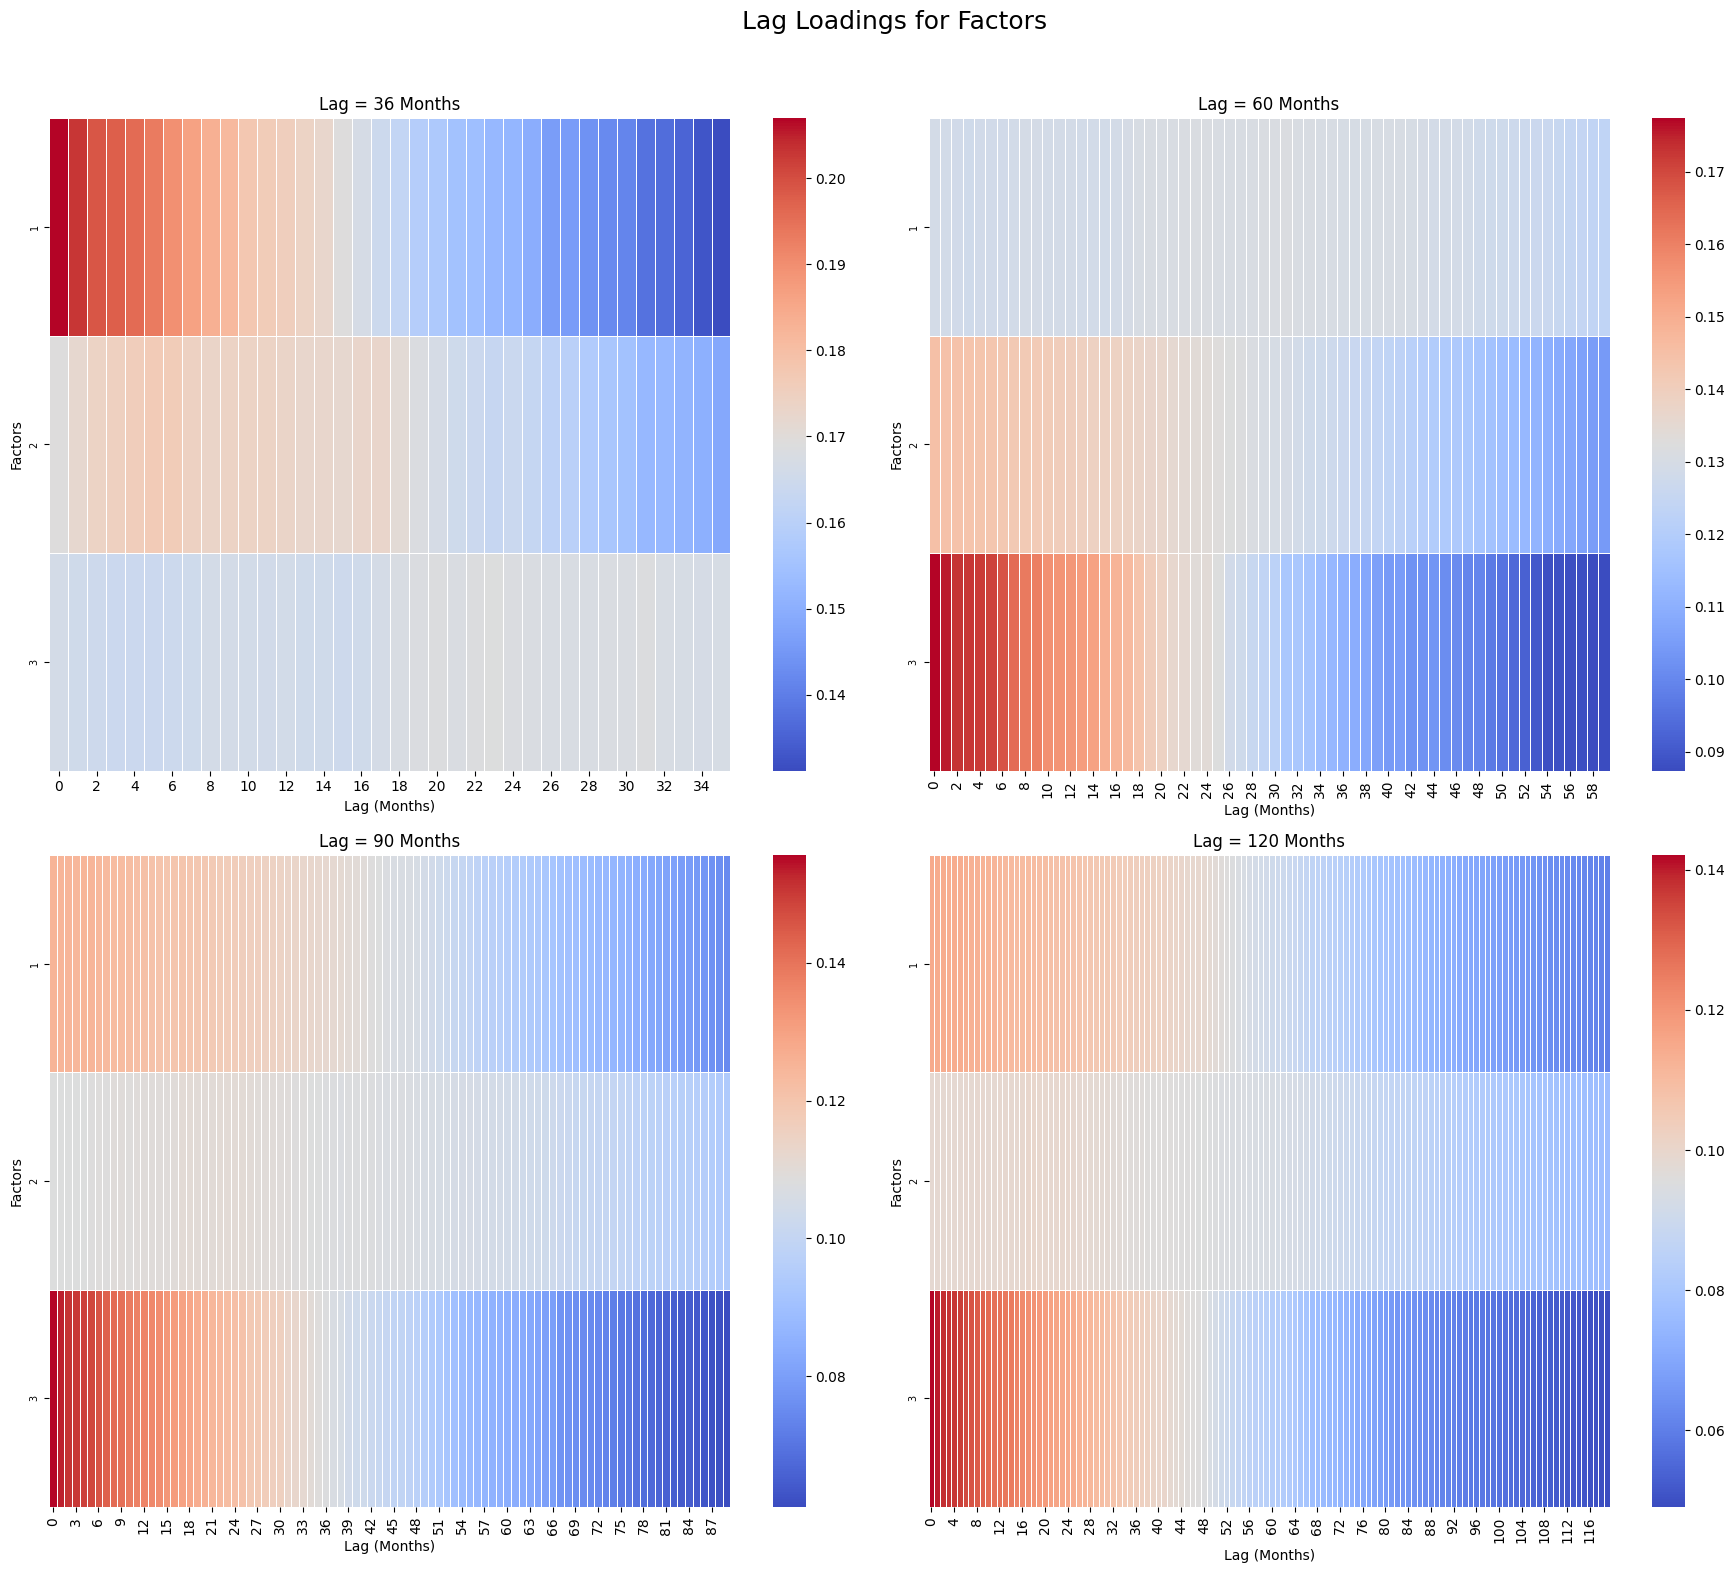

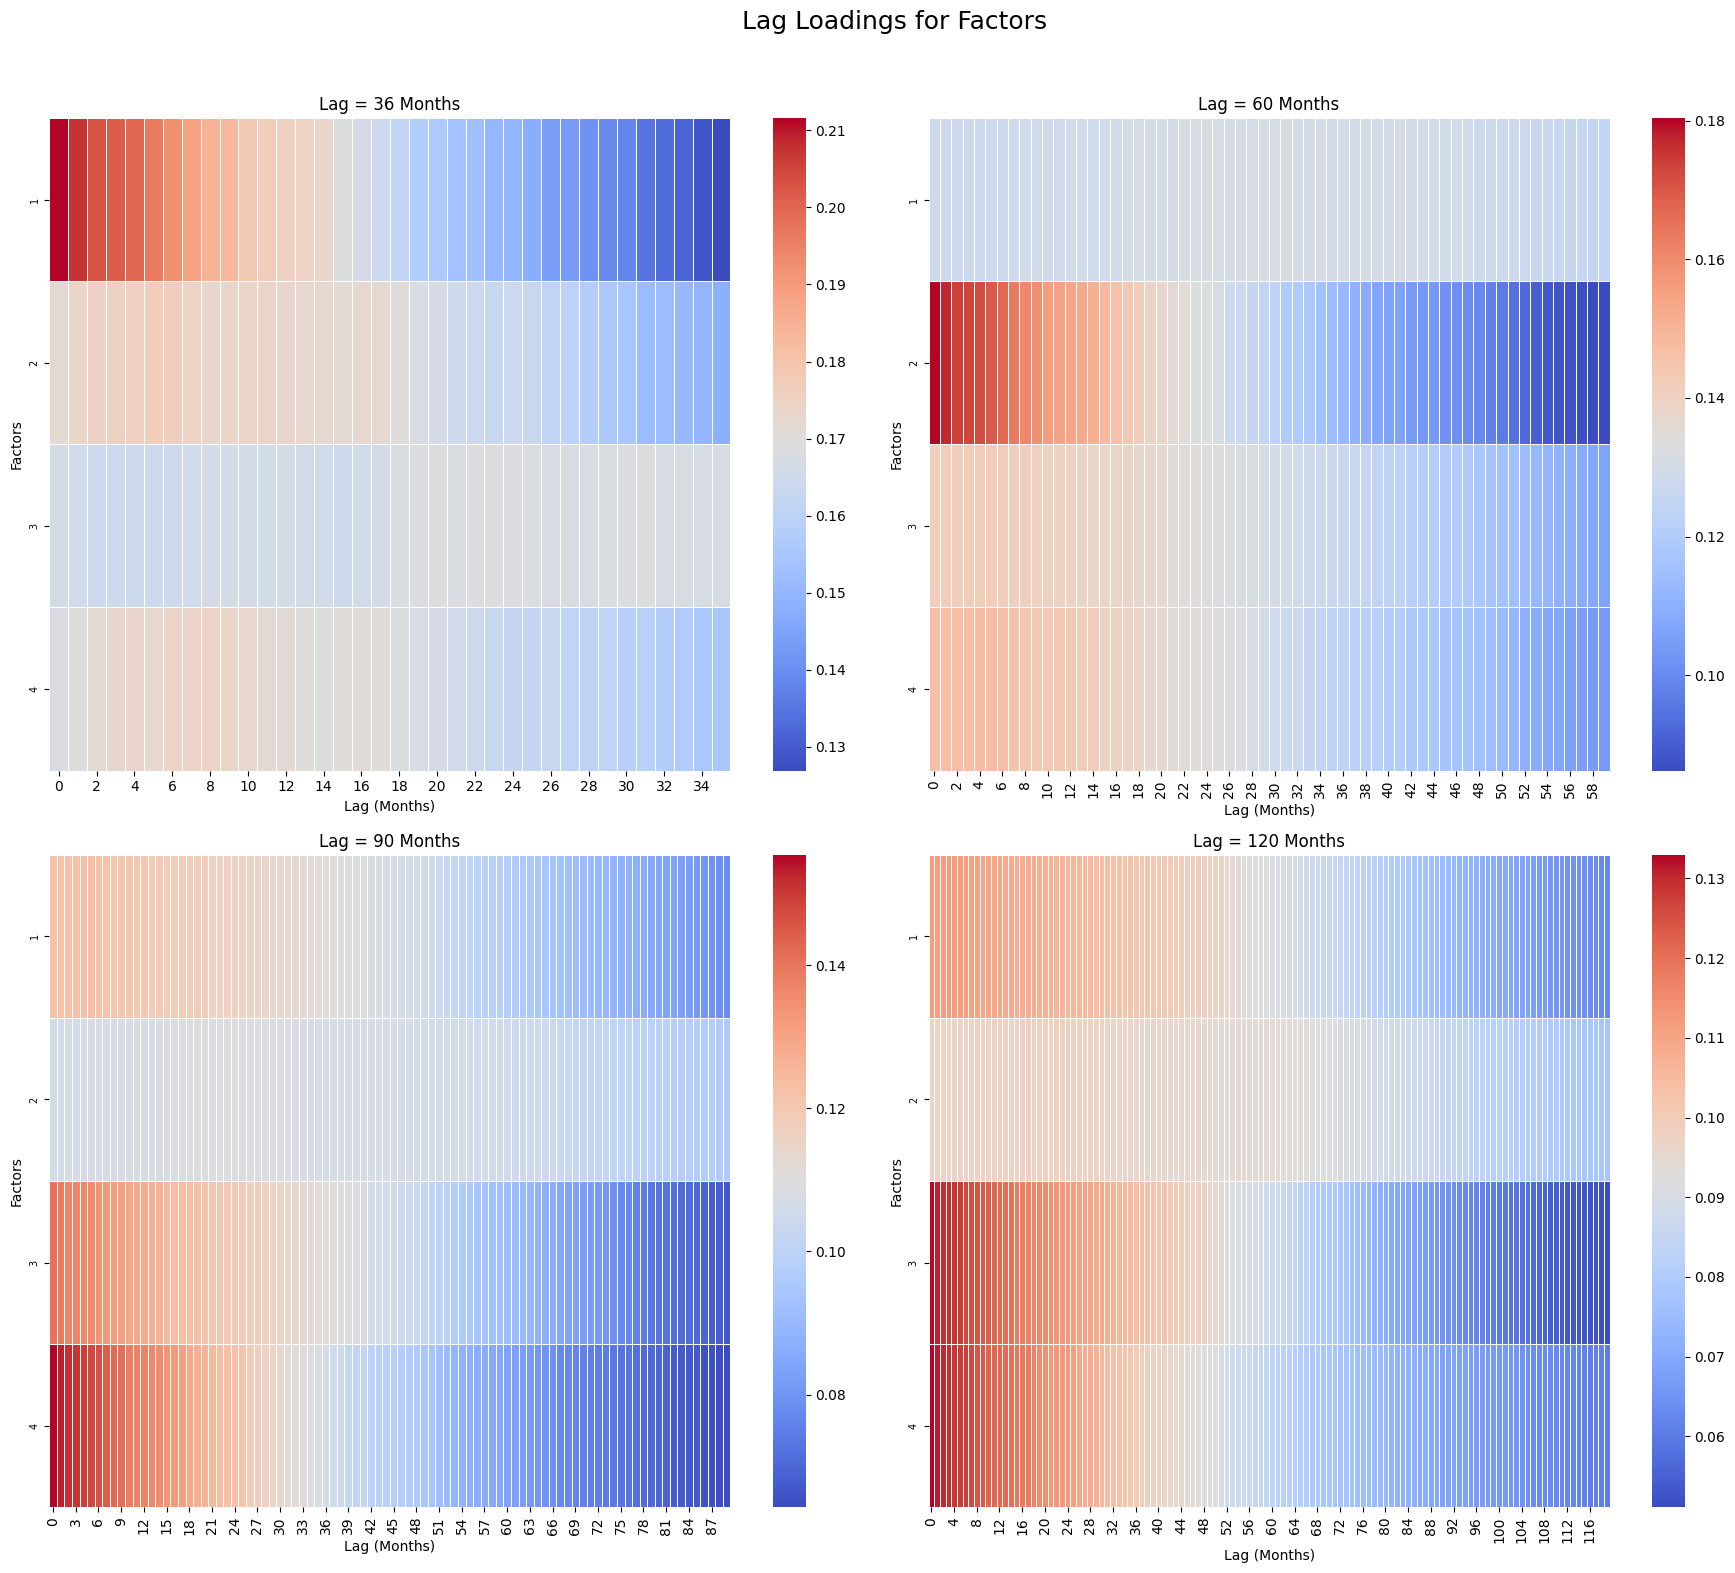

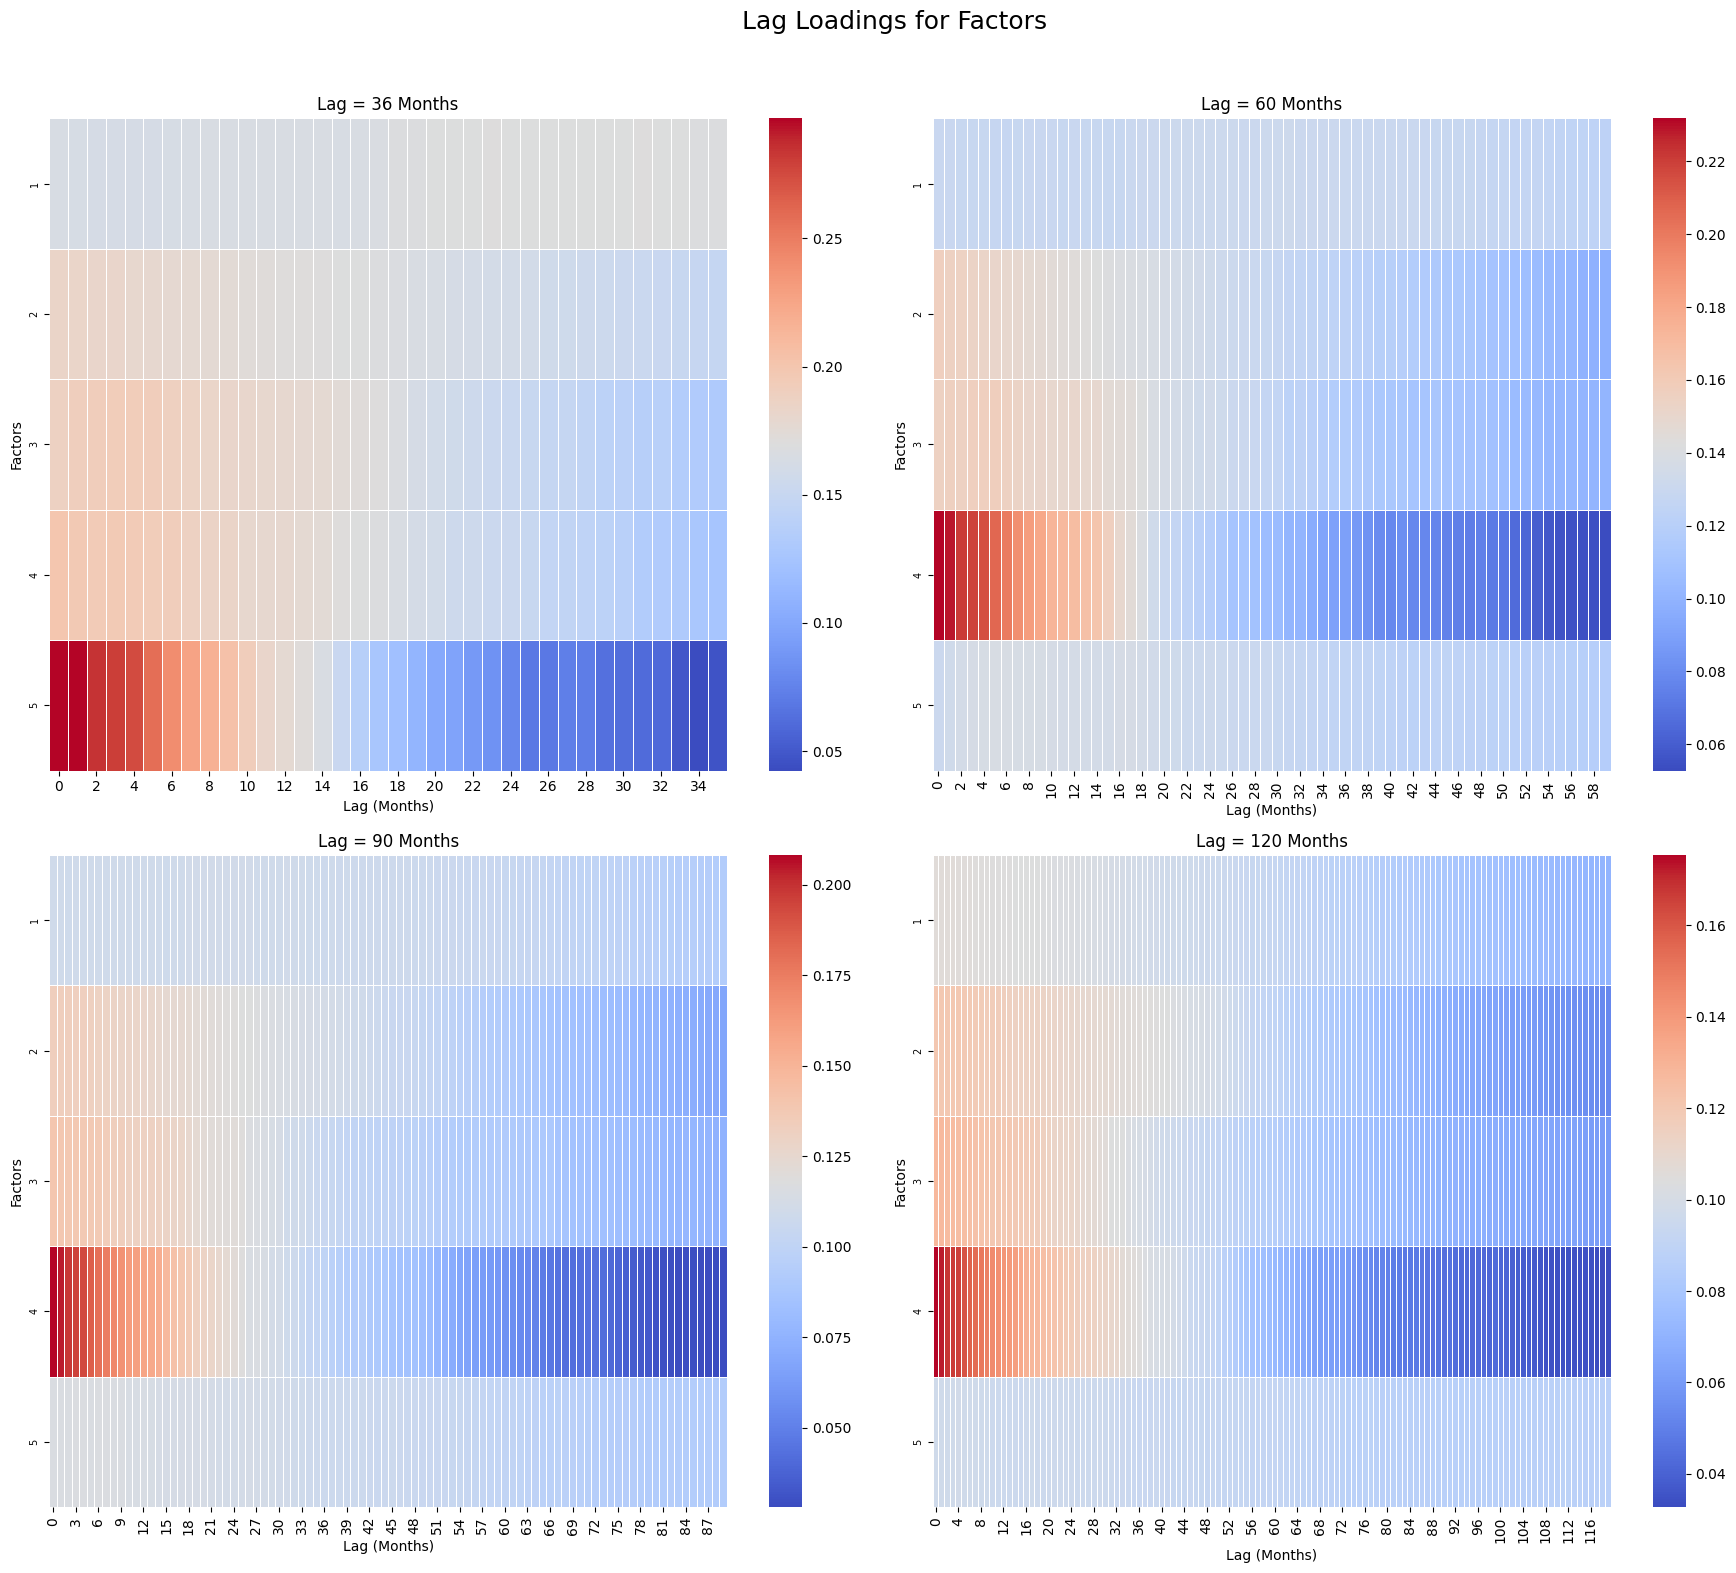

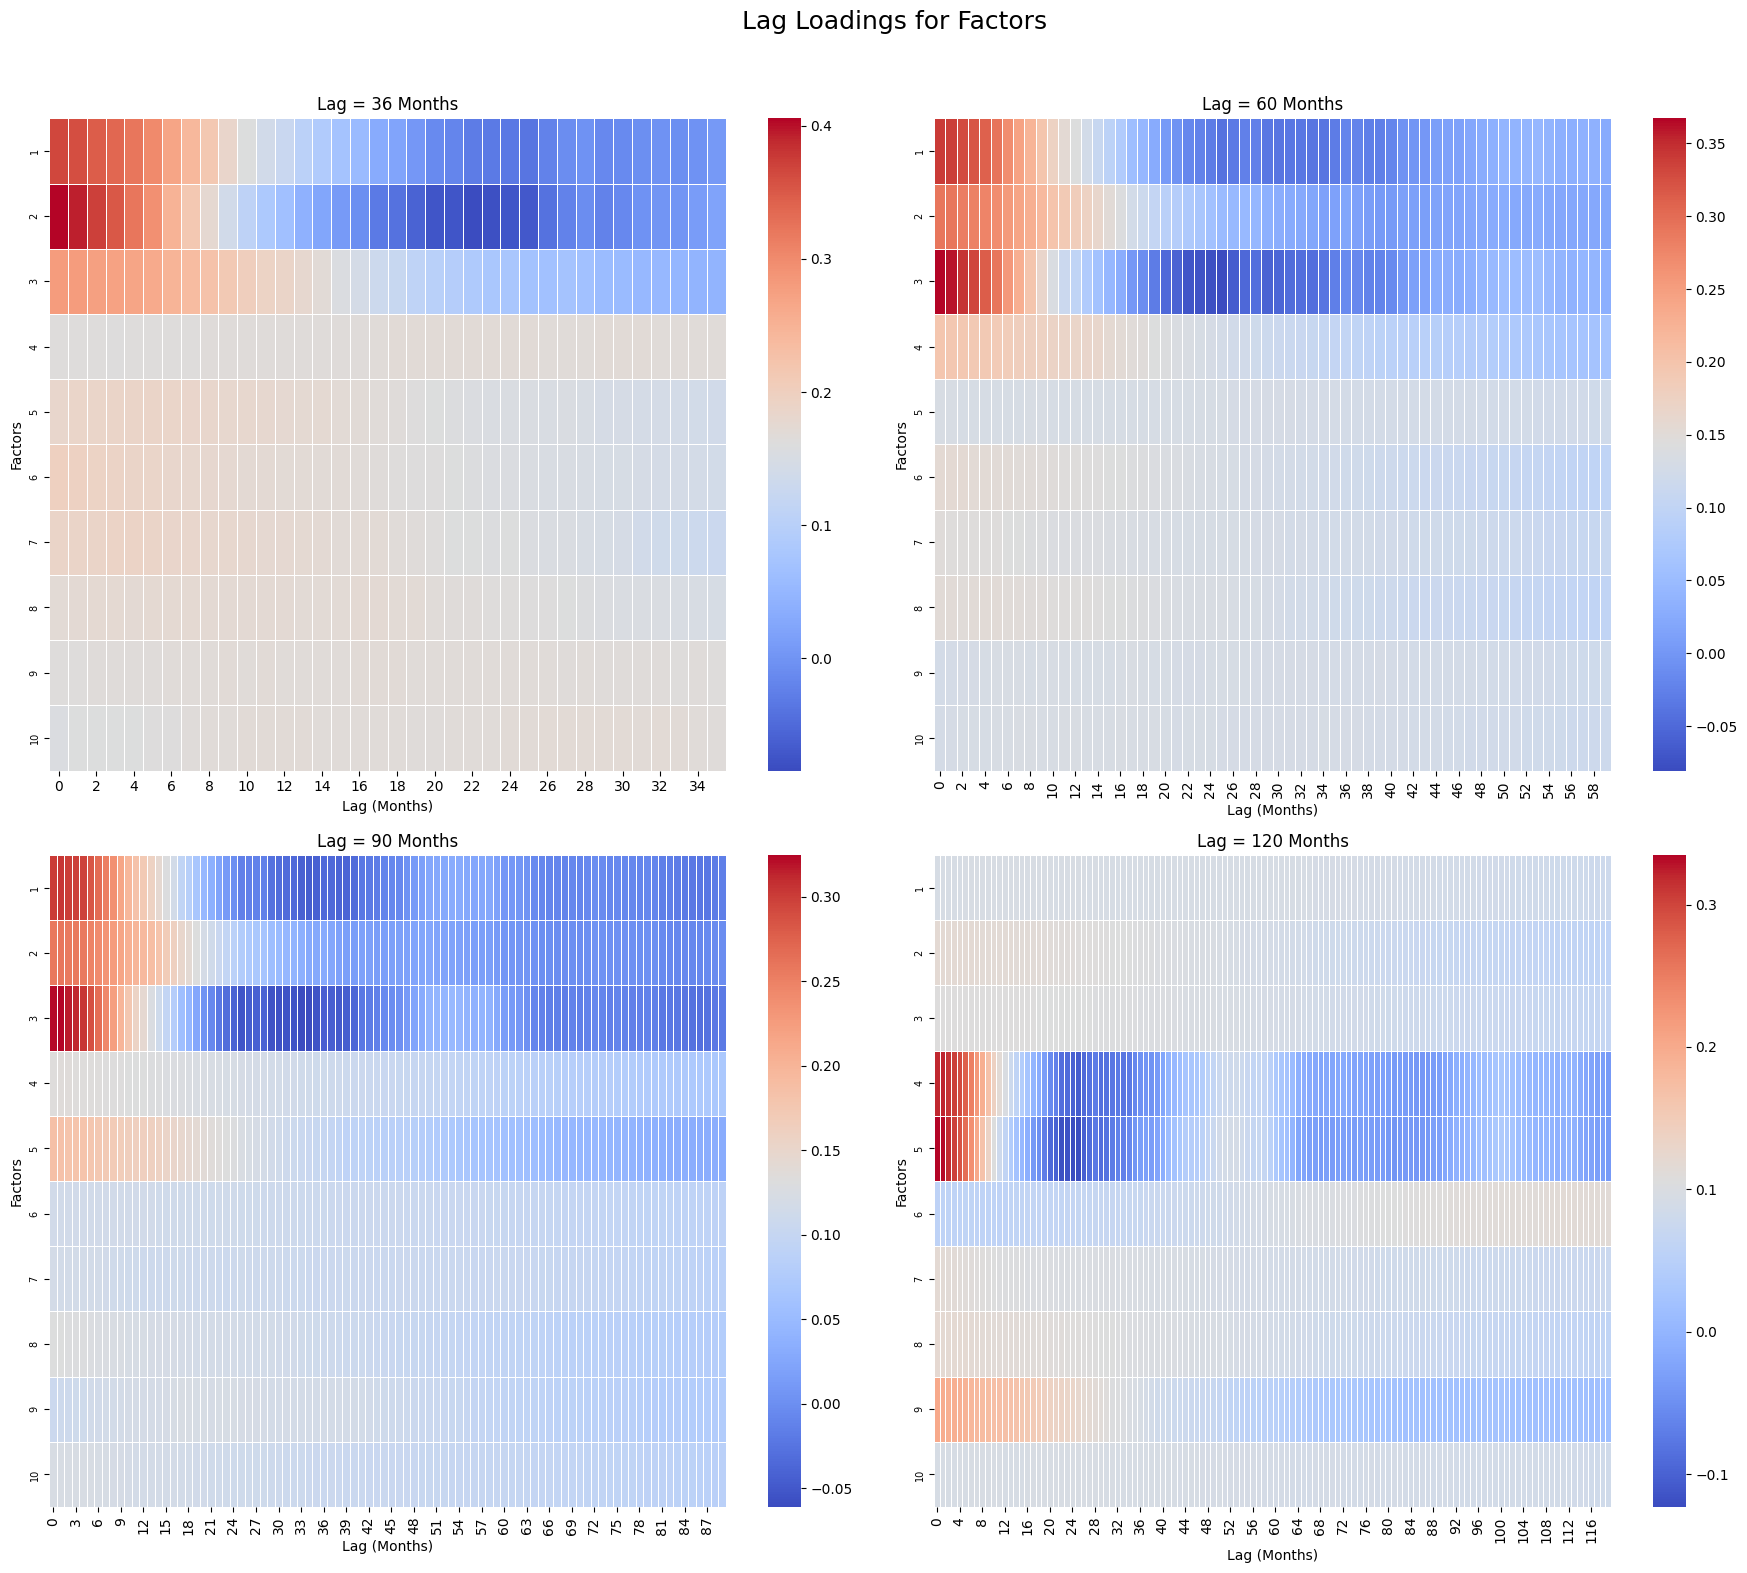

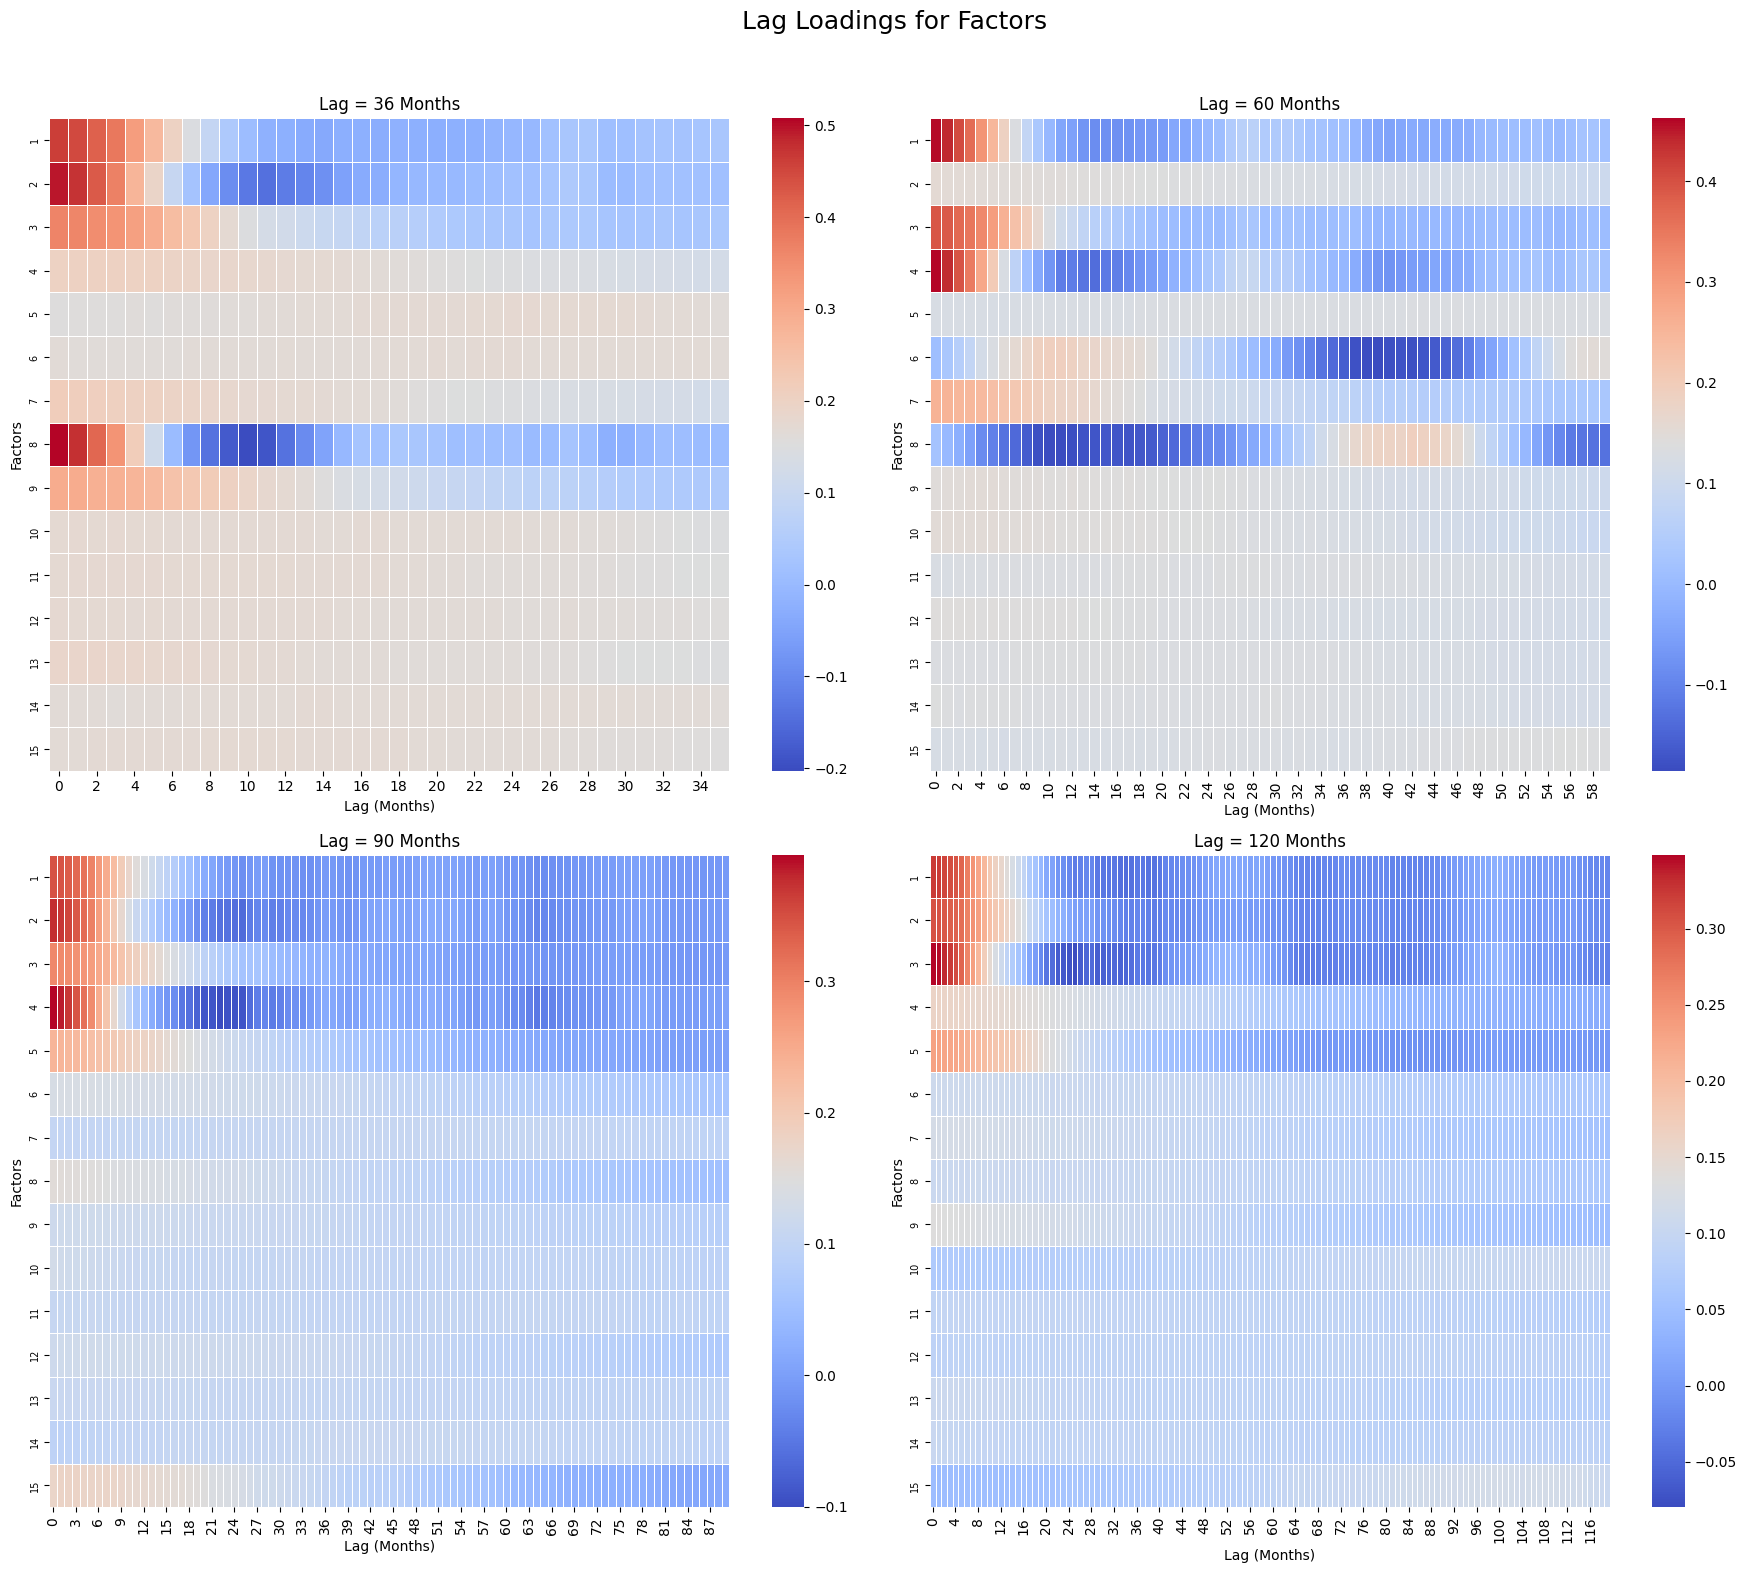

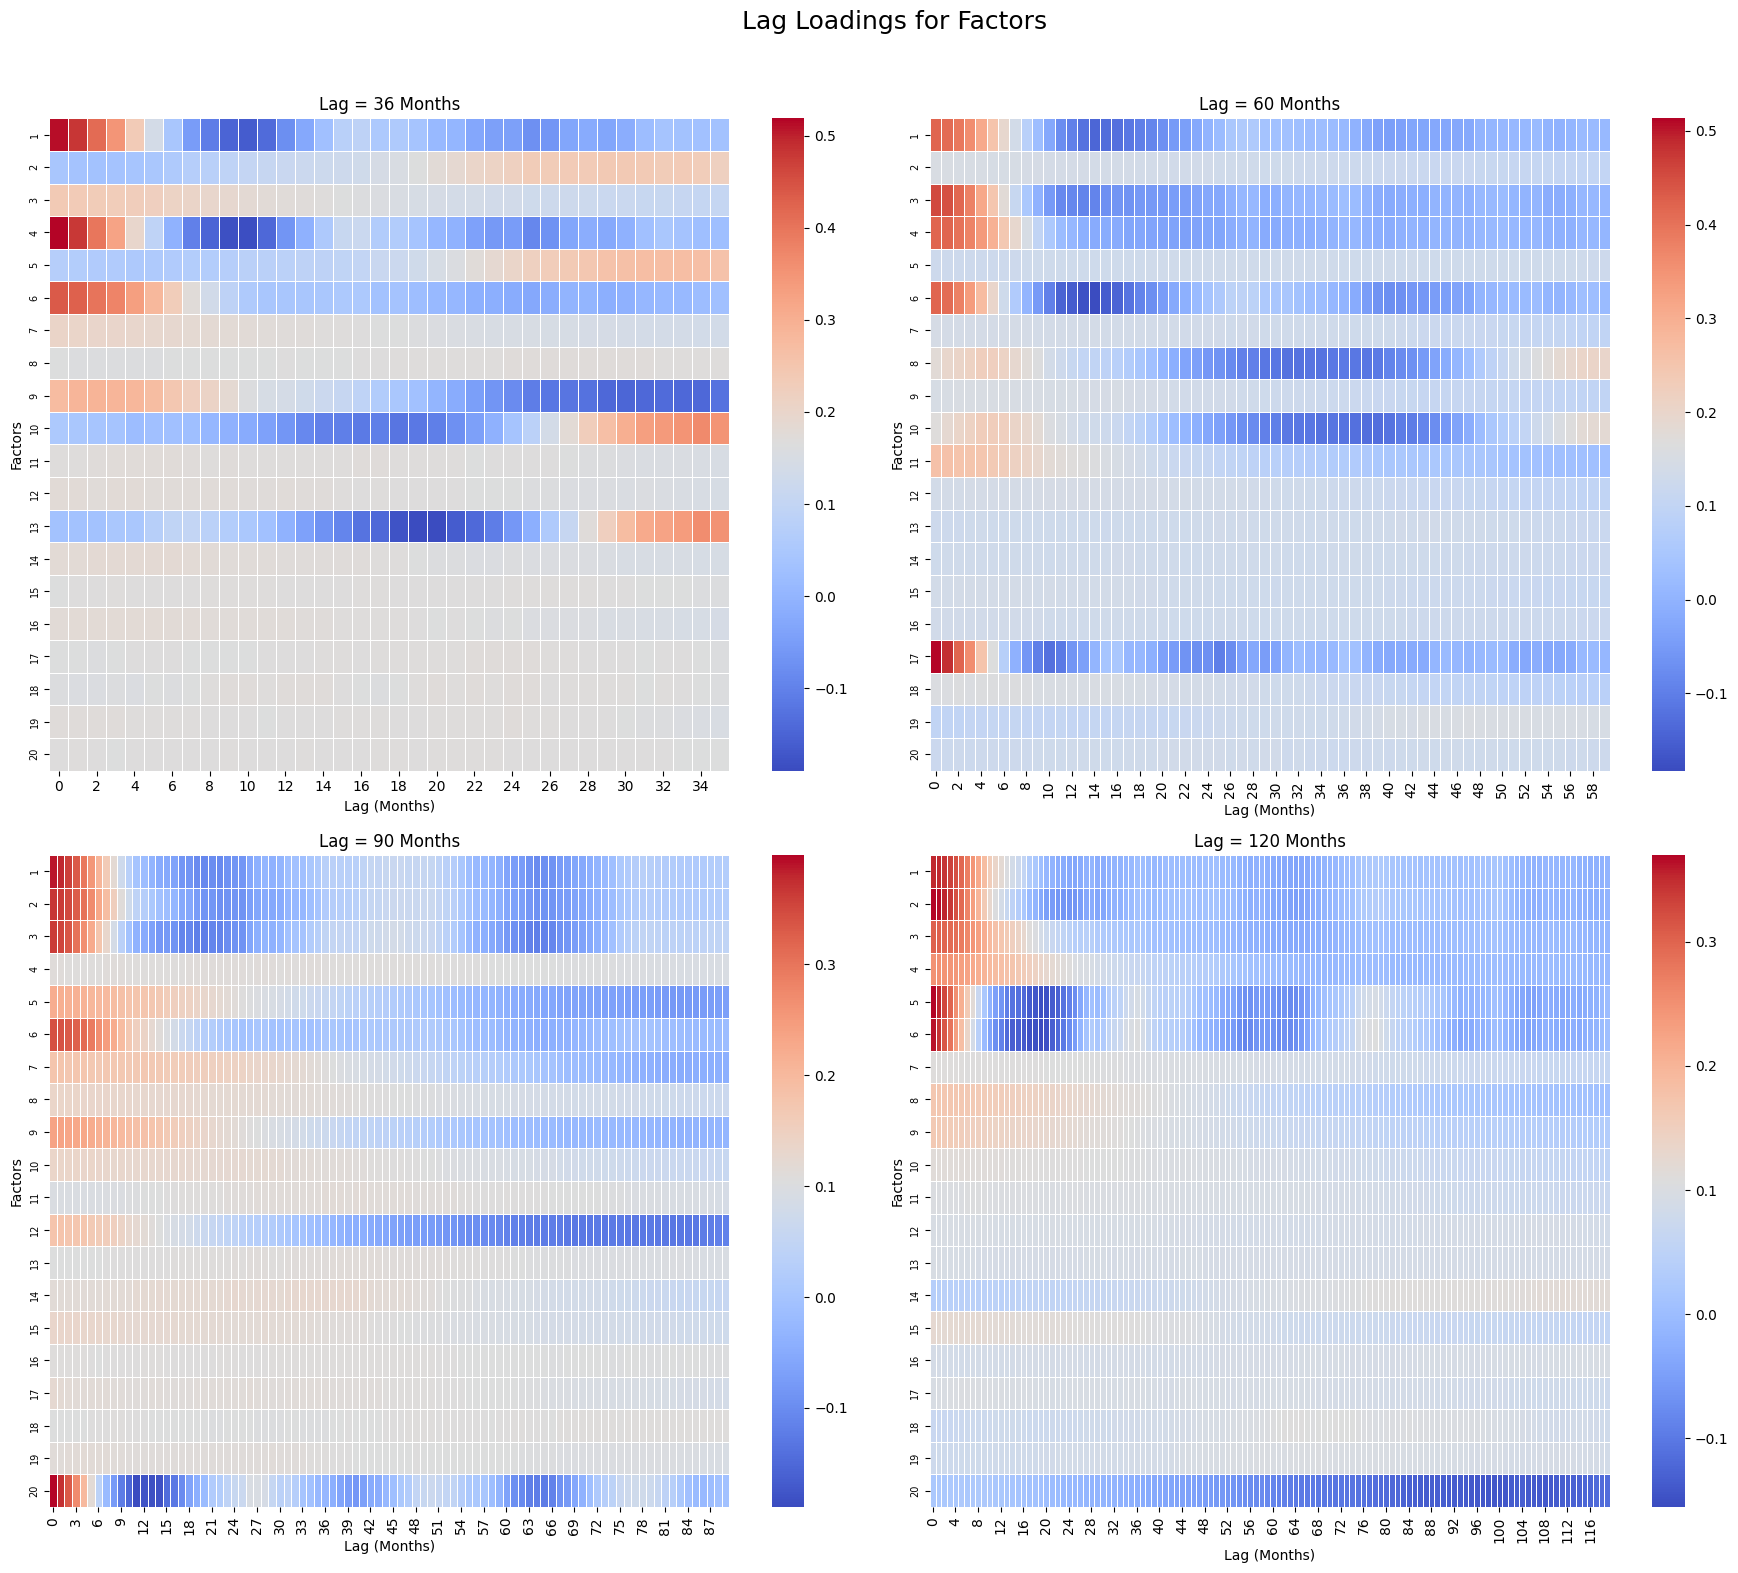

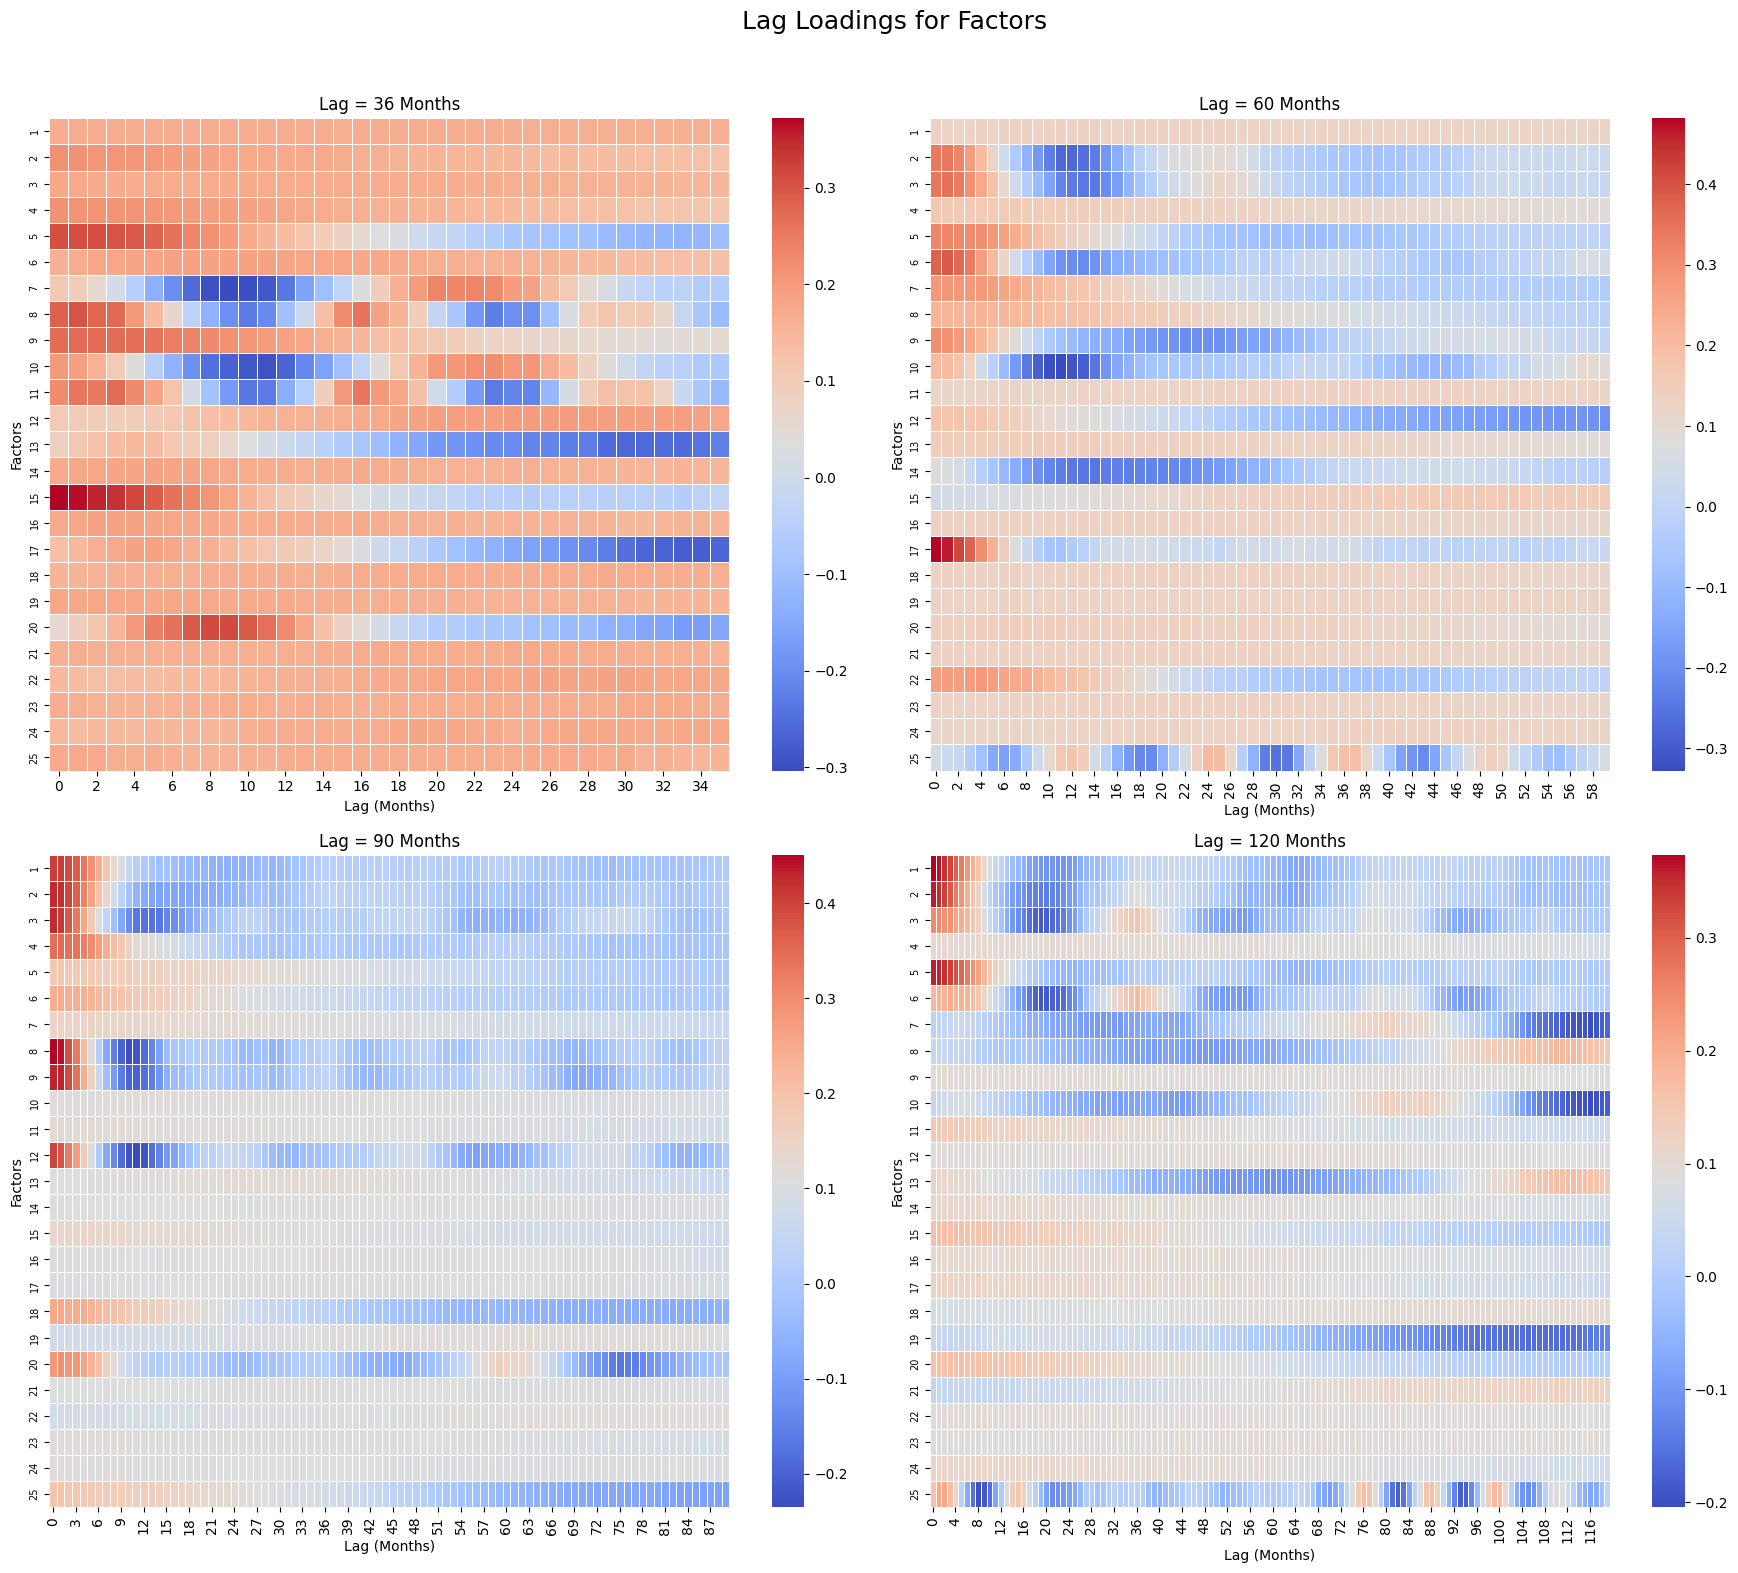

In [32]:
for K in lst_K:
    fig, axes = plt.subplots(2, 2, figsize=(18, 16))
    fig.suptitle(f"Lag Loadings for Factors", fontsize=18)
    for idx, lag in enumerate(lst_lags):
        if idx >= 4:
            break
        
        weights, factors = parafac_enhanced(
            tensor=X_log[:, :lag, :],
            rank=K,
            random_state=random_seed,
            n_iter_max=n_iter_max,
            fix_intercept_mode=1,
        )

        # Extract and normalize factors
        factors = dict(zip(['F','W','B'], factors))
        factors['S'] = weights
        factors = normalize_factors(factors, reorder=True)
        F, W, B, S = [factors[key] for key in ['F','W','B','S']]
        
        ax = axes[idx // 2, idx % 2]
        sns.heatmap(W.T, cmap='coolwarm', annot=False, fmt=".2f", linewidths=0.5, ax=ax)
        ax.set_yticklabels(jnp.arange(K) + 1, fontsize=7)
        ax.set_xlabel("Lag (Months)")
        ax.set_ylabel("Factors")
        ax.set_title(f'Lag = {lag} Months')

    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit main title
    plt.savefig(f"../interpretability/figures/W_{K}.png")
    plt.show()

# 4. Lag Loadings for Characteristic-Based Portfolios
The formula of interest is
$$\theta^{B, H} = B(B^\top B)^{-1} \theta^{H}$$
where $B \in \mathbb{R}^{N \times K}, \theta^H \in \mathbb{R}^K, \text{ and } \theta^{B, H} \in \mathbb{R}^N$. Note that $B$ is like betas, they give us the mapping from the latent factor subspace back to the characteristic-based factor space. 
Similarly, 
$$W^B = W (B^\top B)^{-1} B^\top \in \mathbb{R}^{L \times N}$$
These lag loadings on the original portfolios aren't normalized, so normalize them such that each ptf has unit norm. Then we plot this below. Currently, in this plot $W$ and $B$ are estimated using the full-sample. 

We can observe these latent factor lag loadings as functions of both $K$ and lag


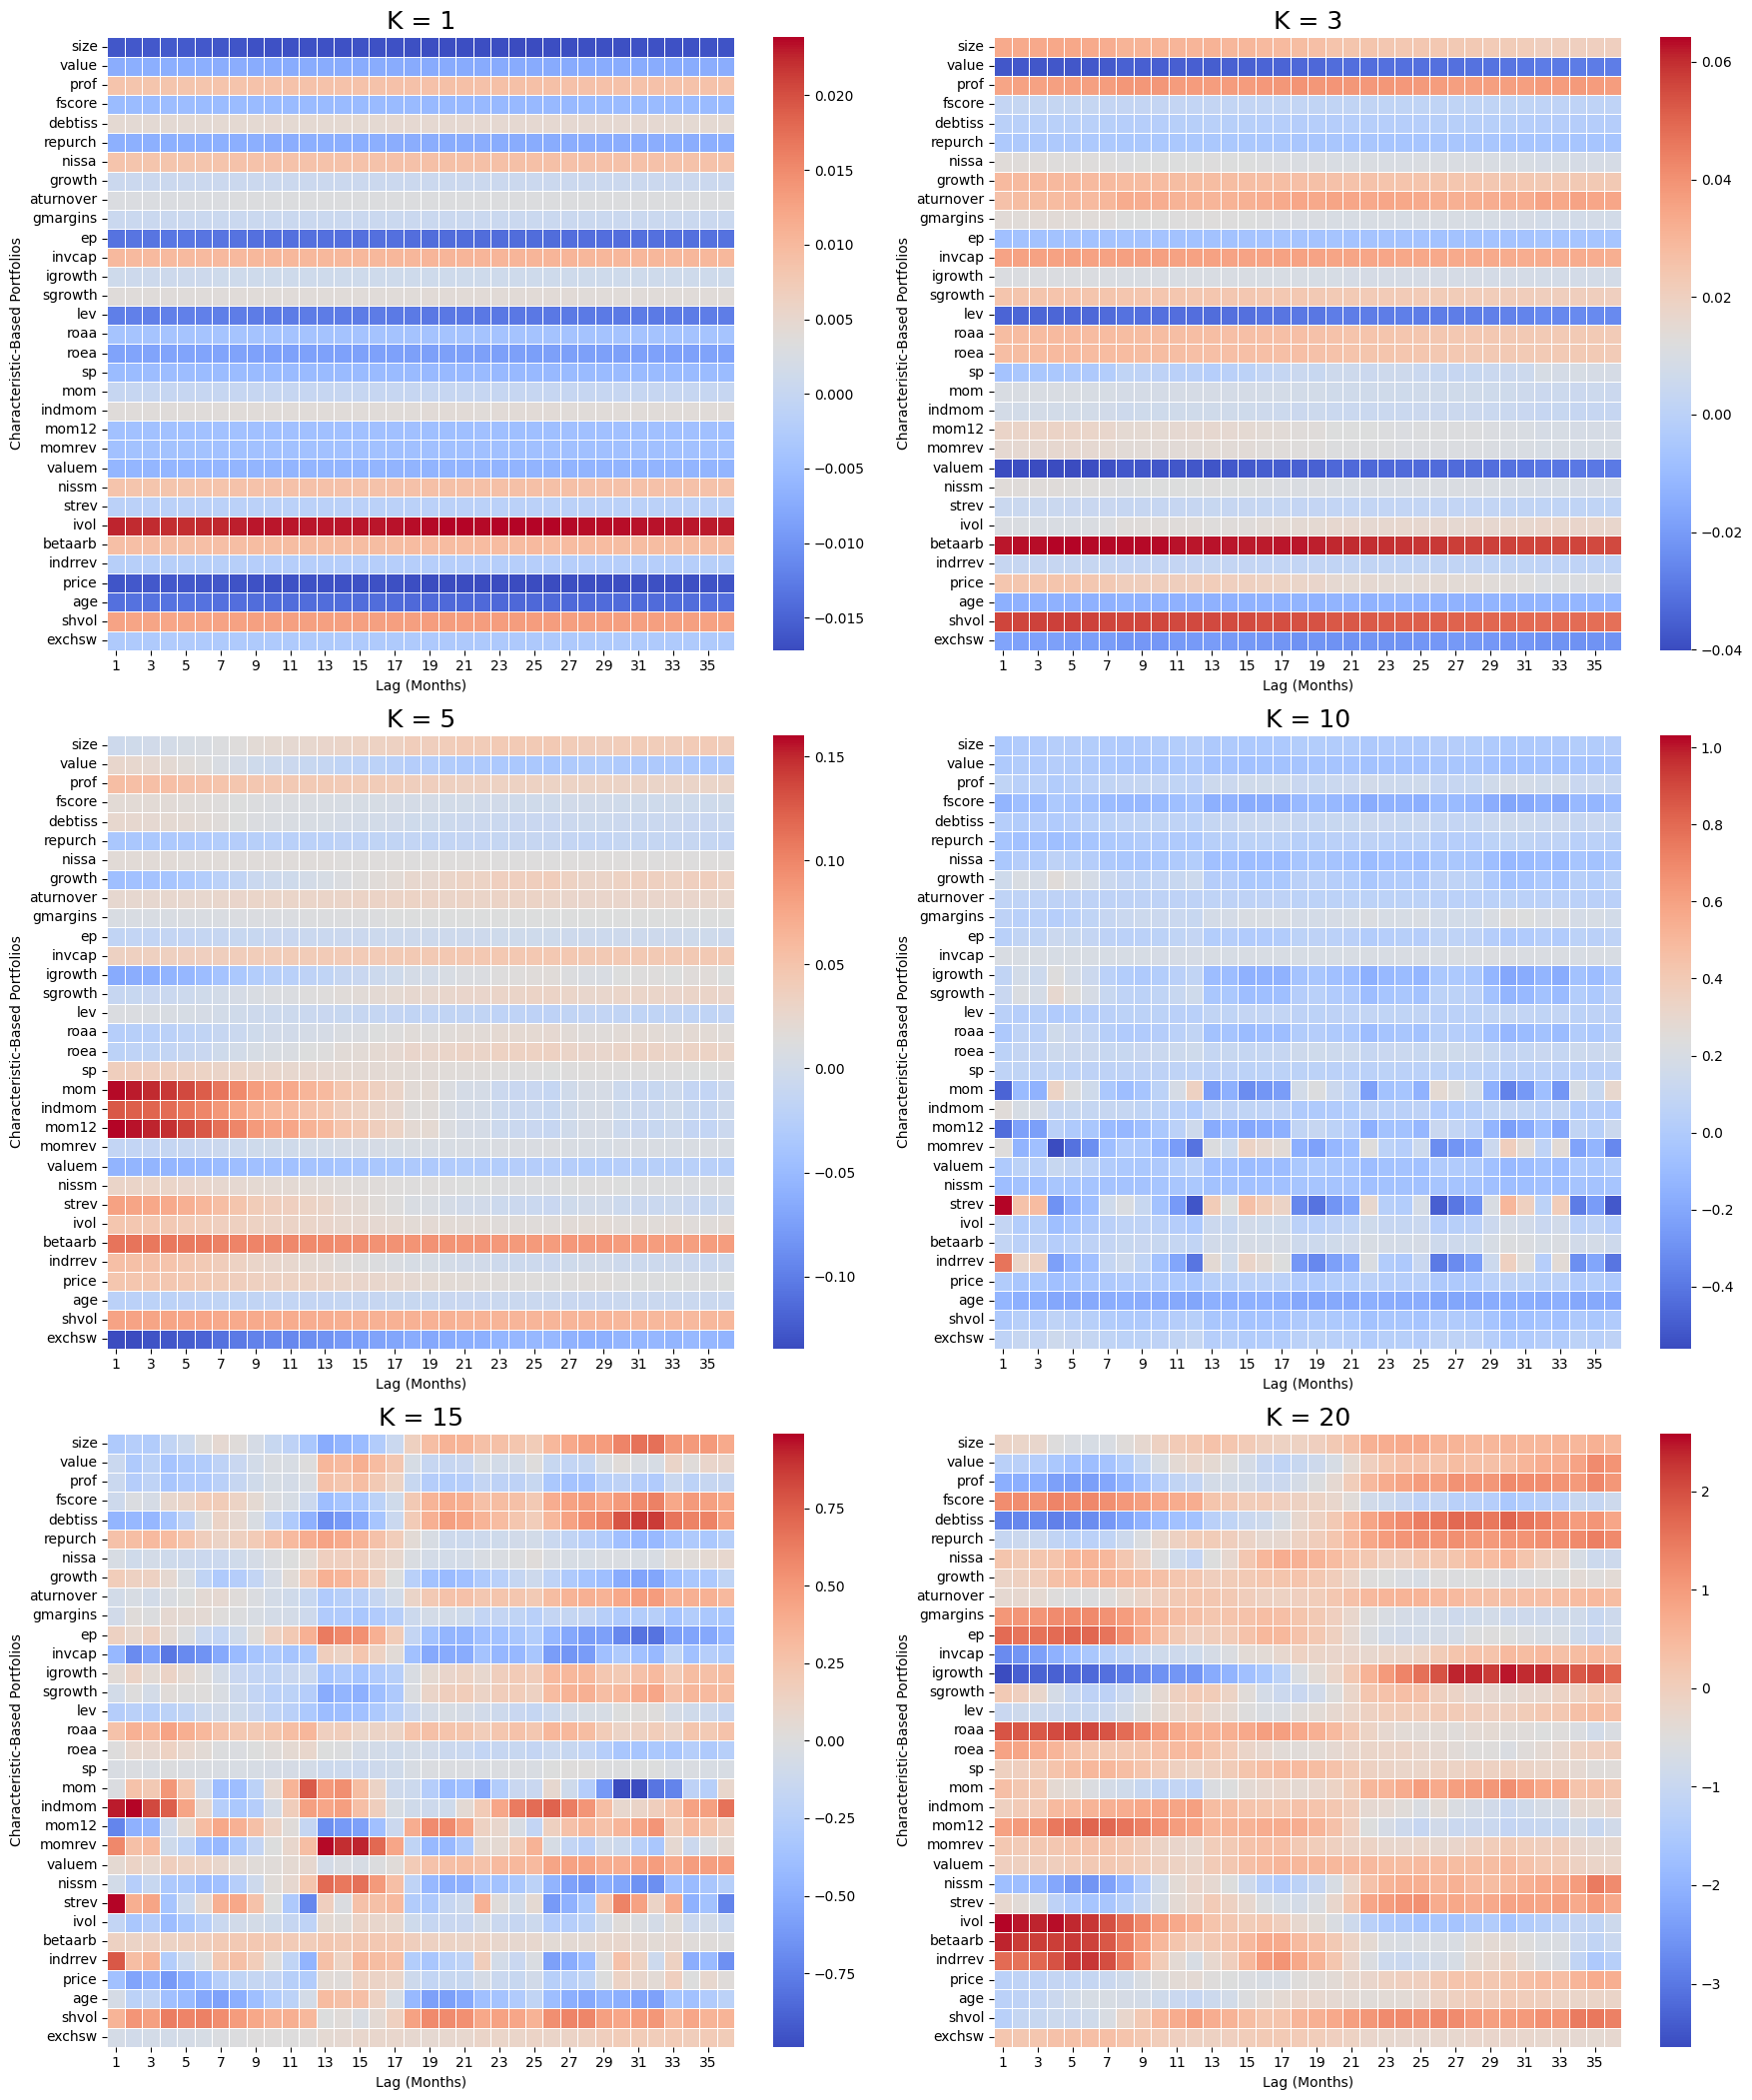

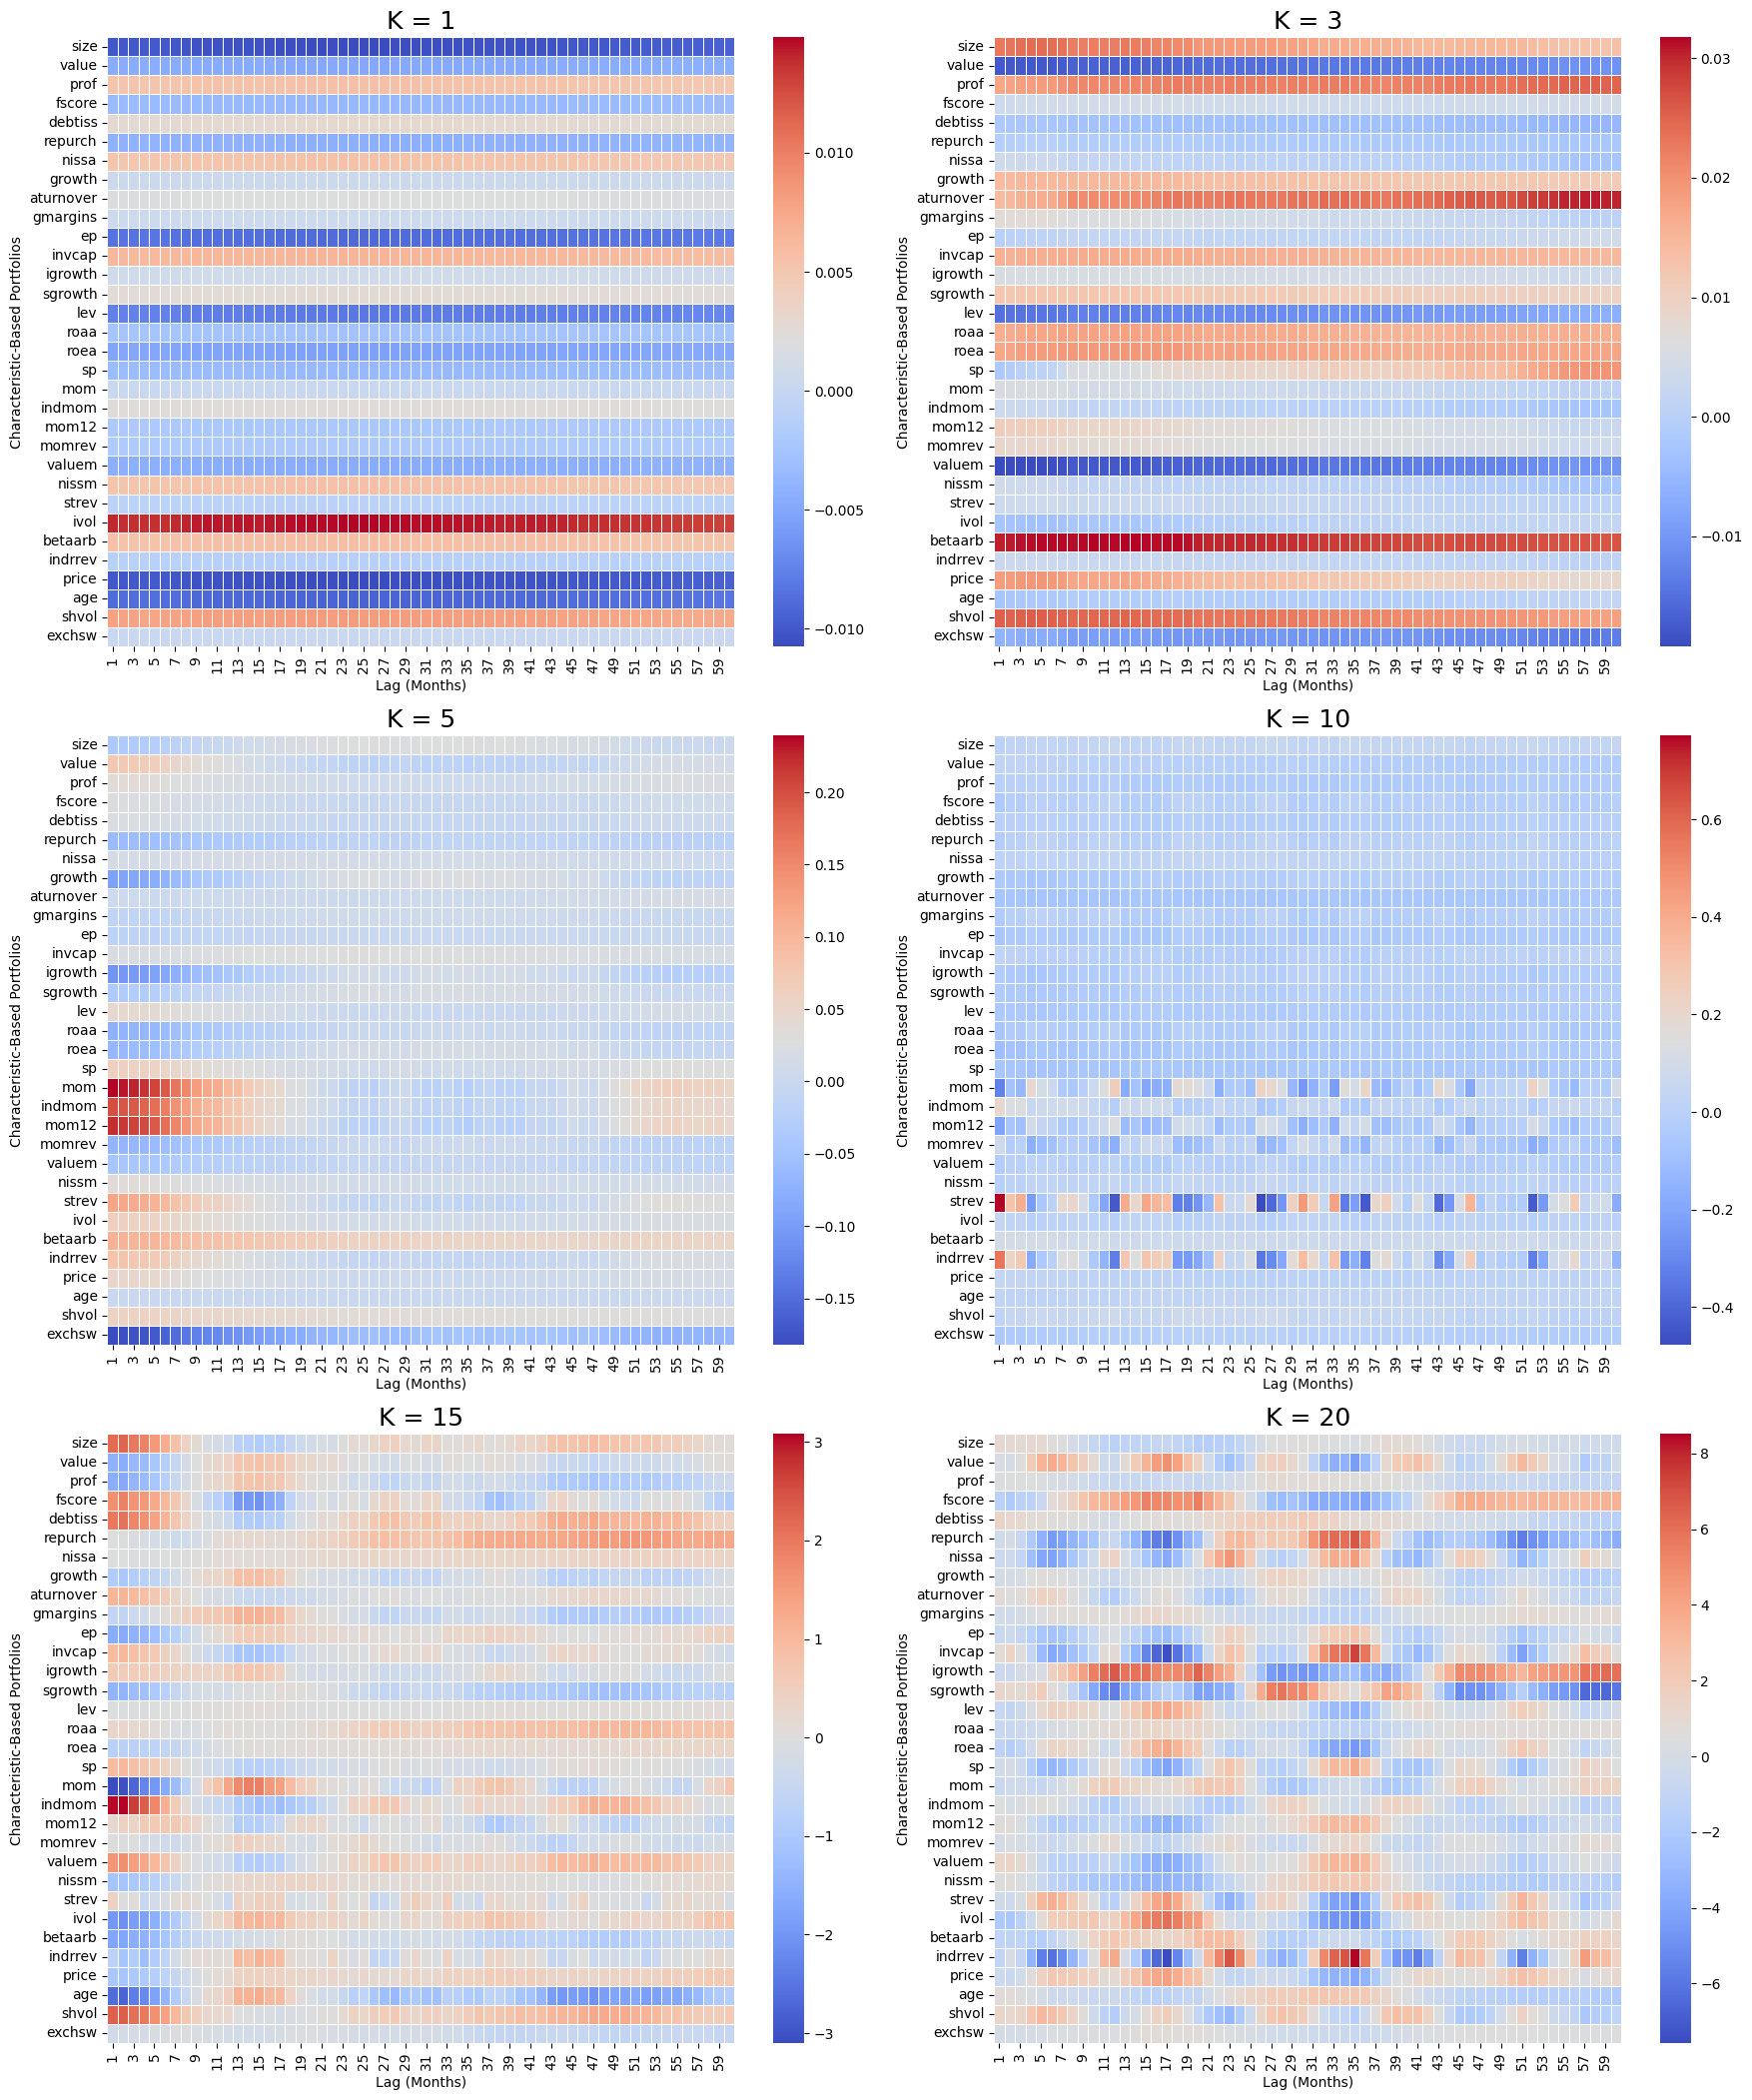

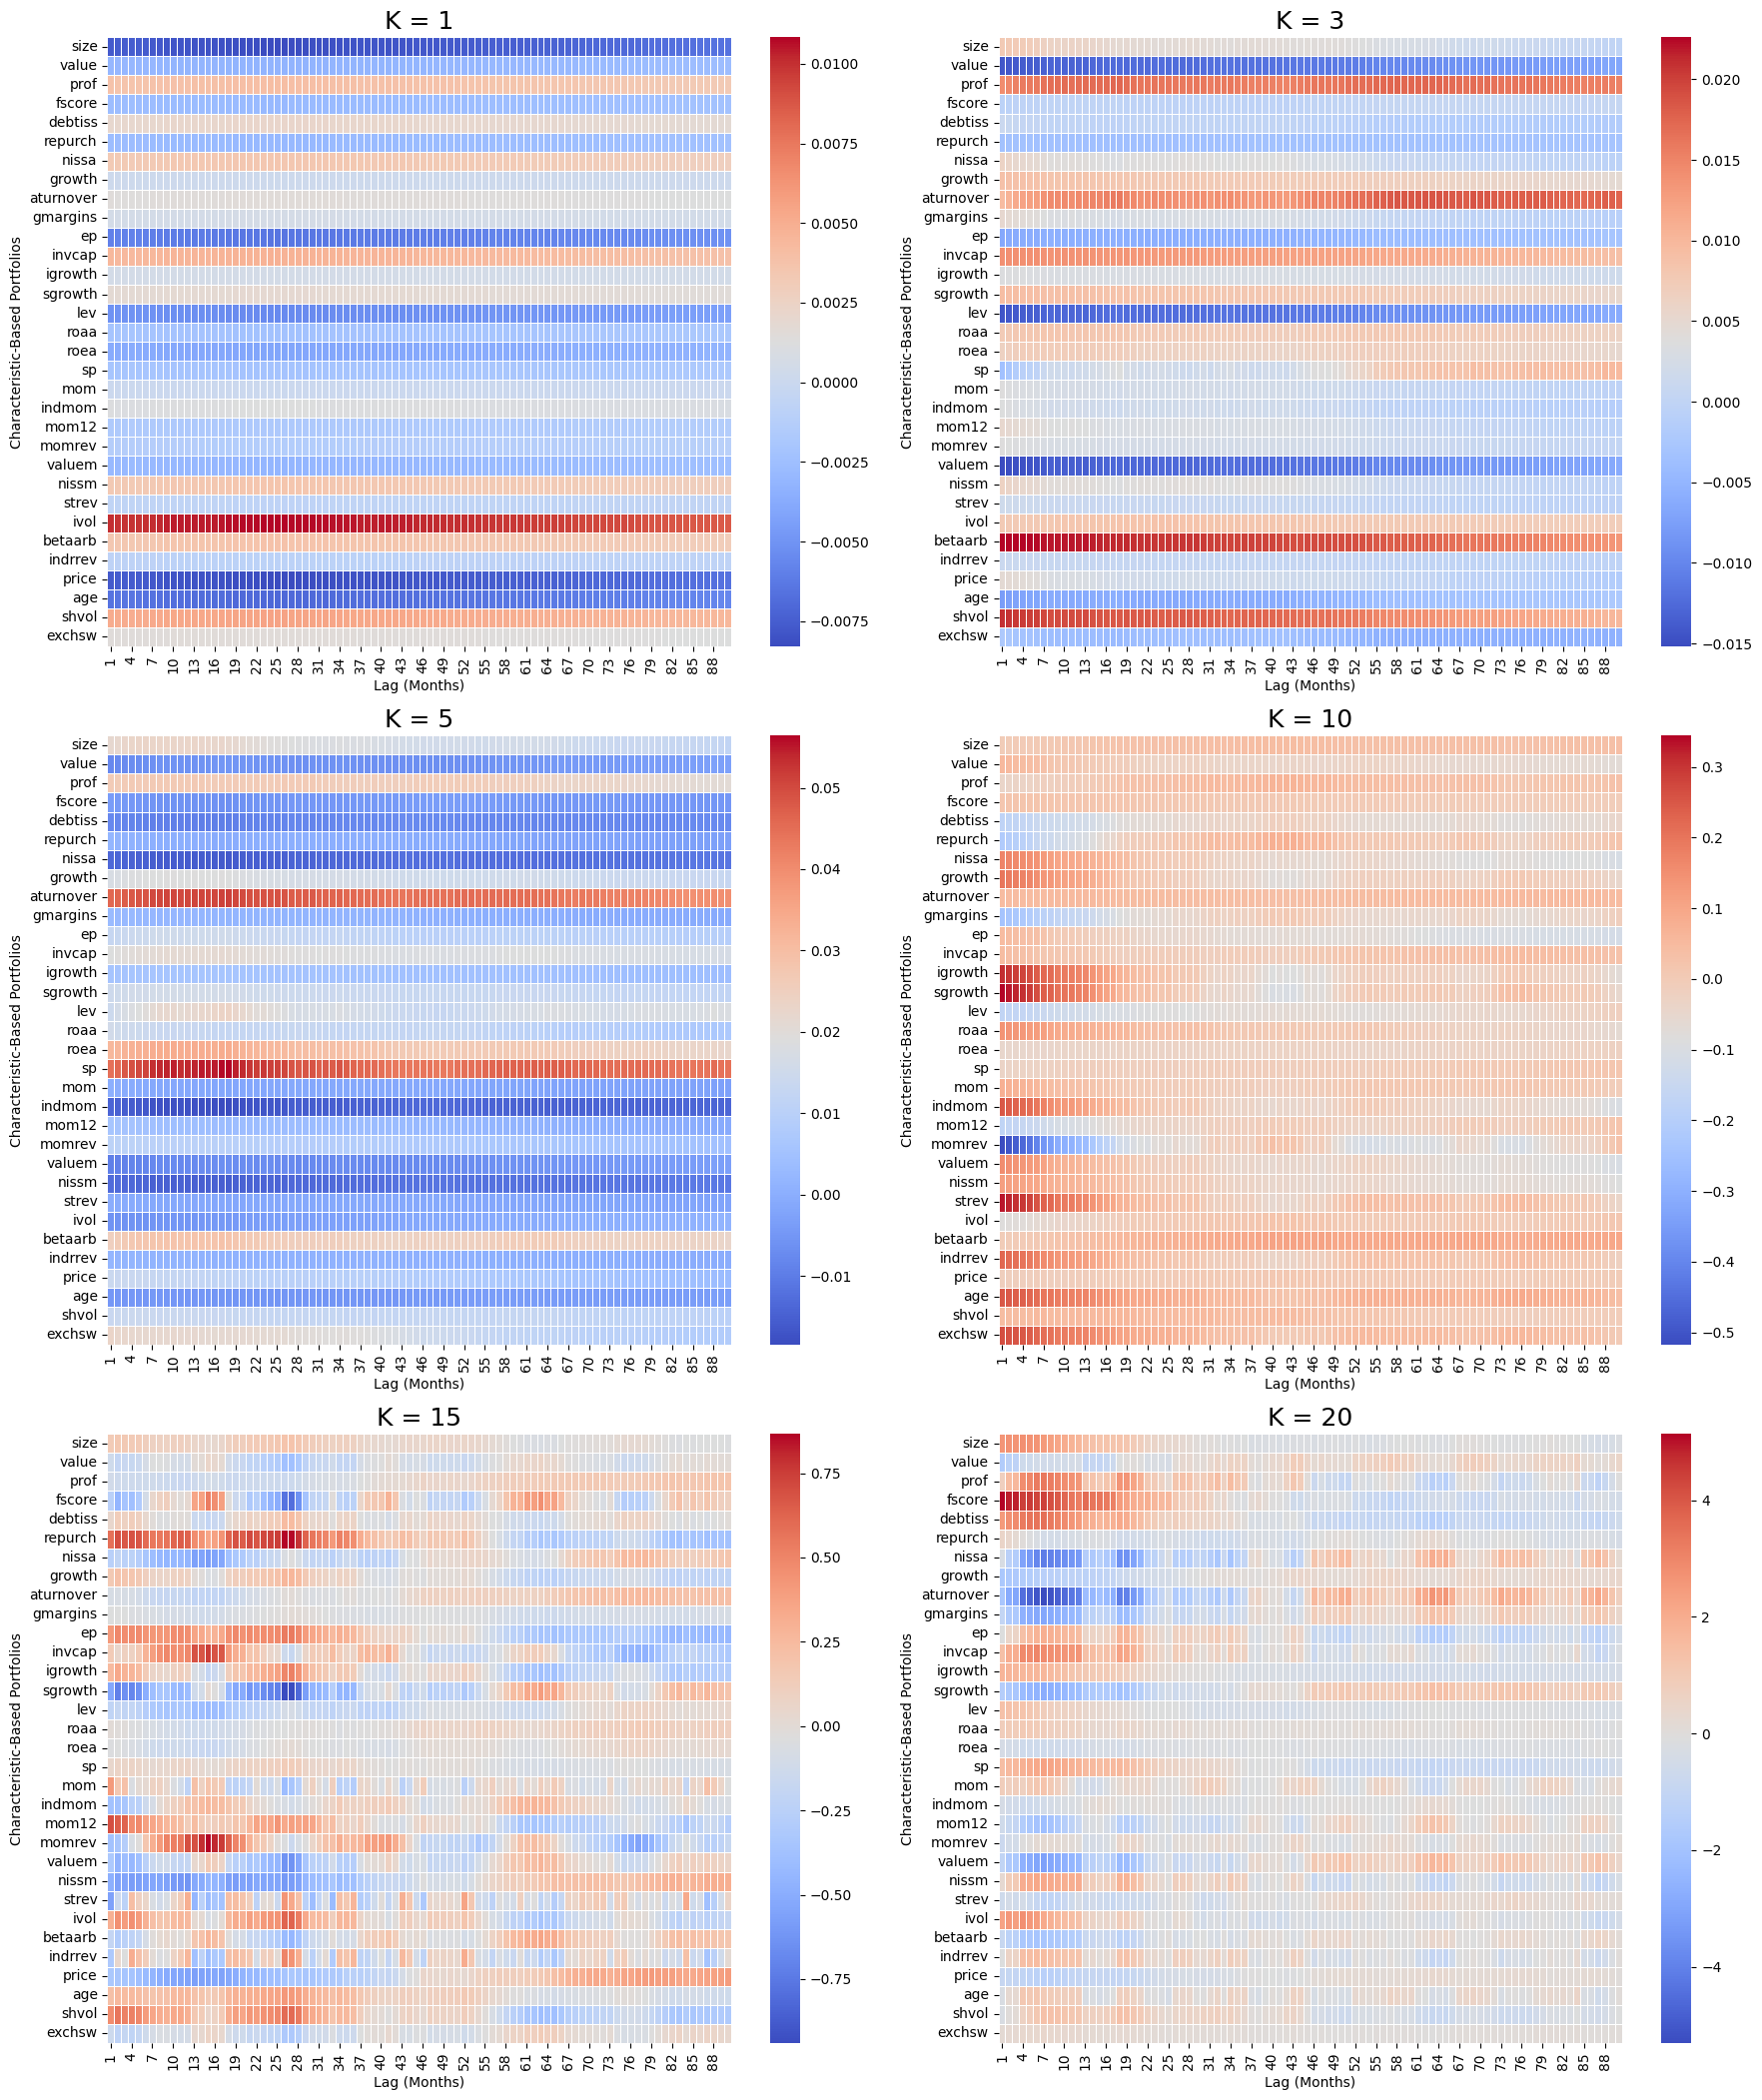

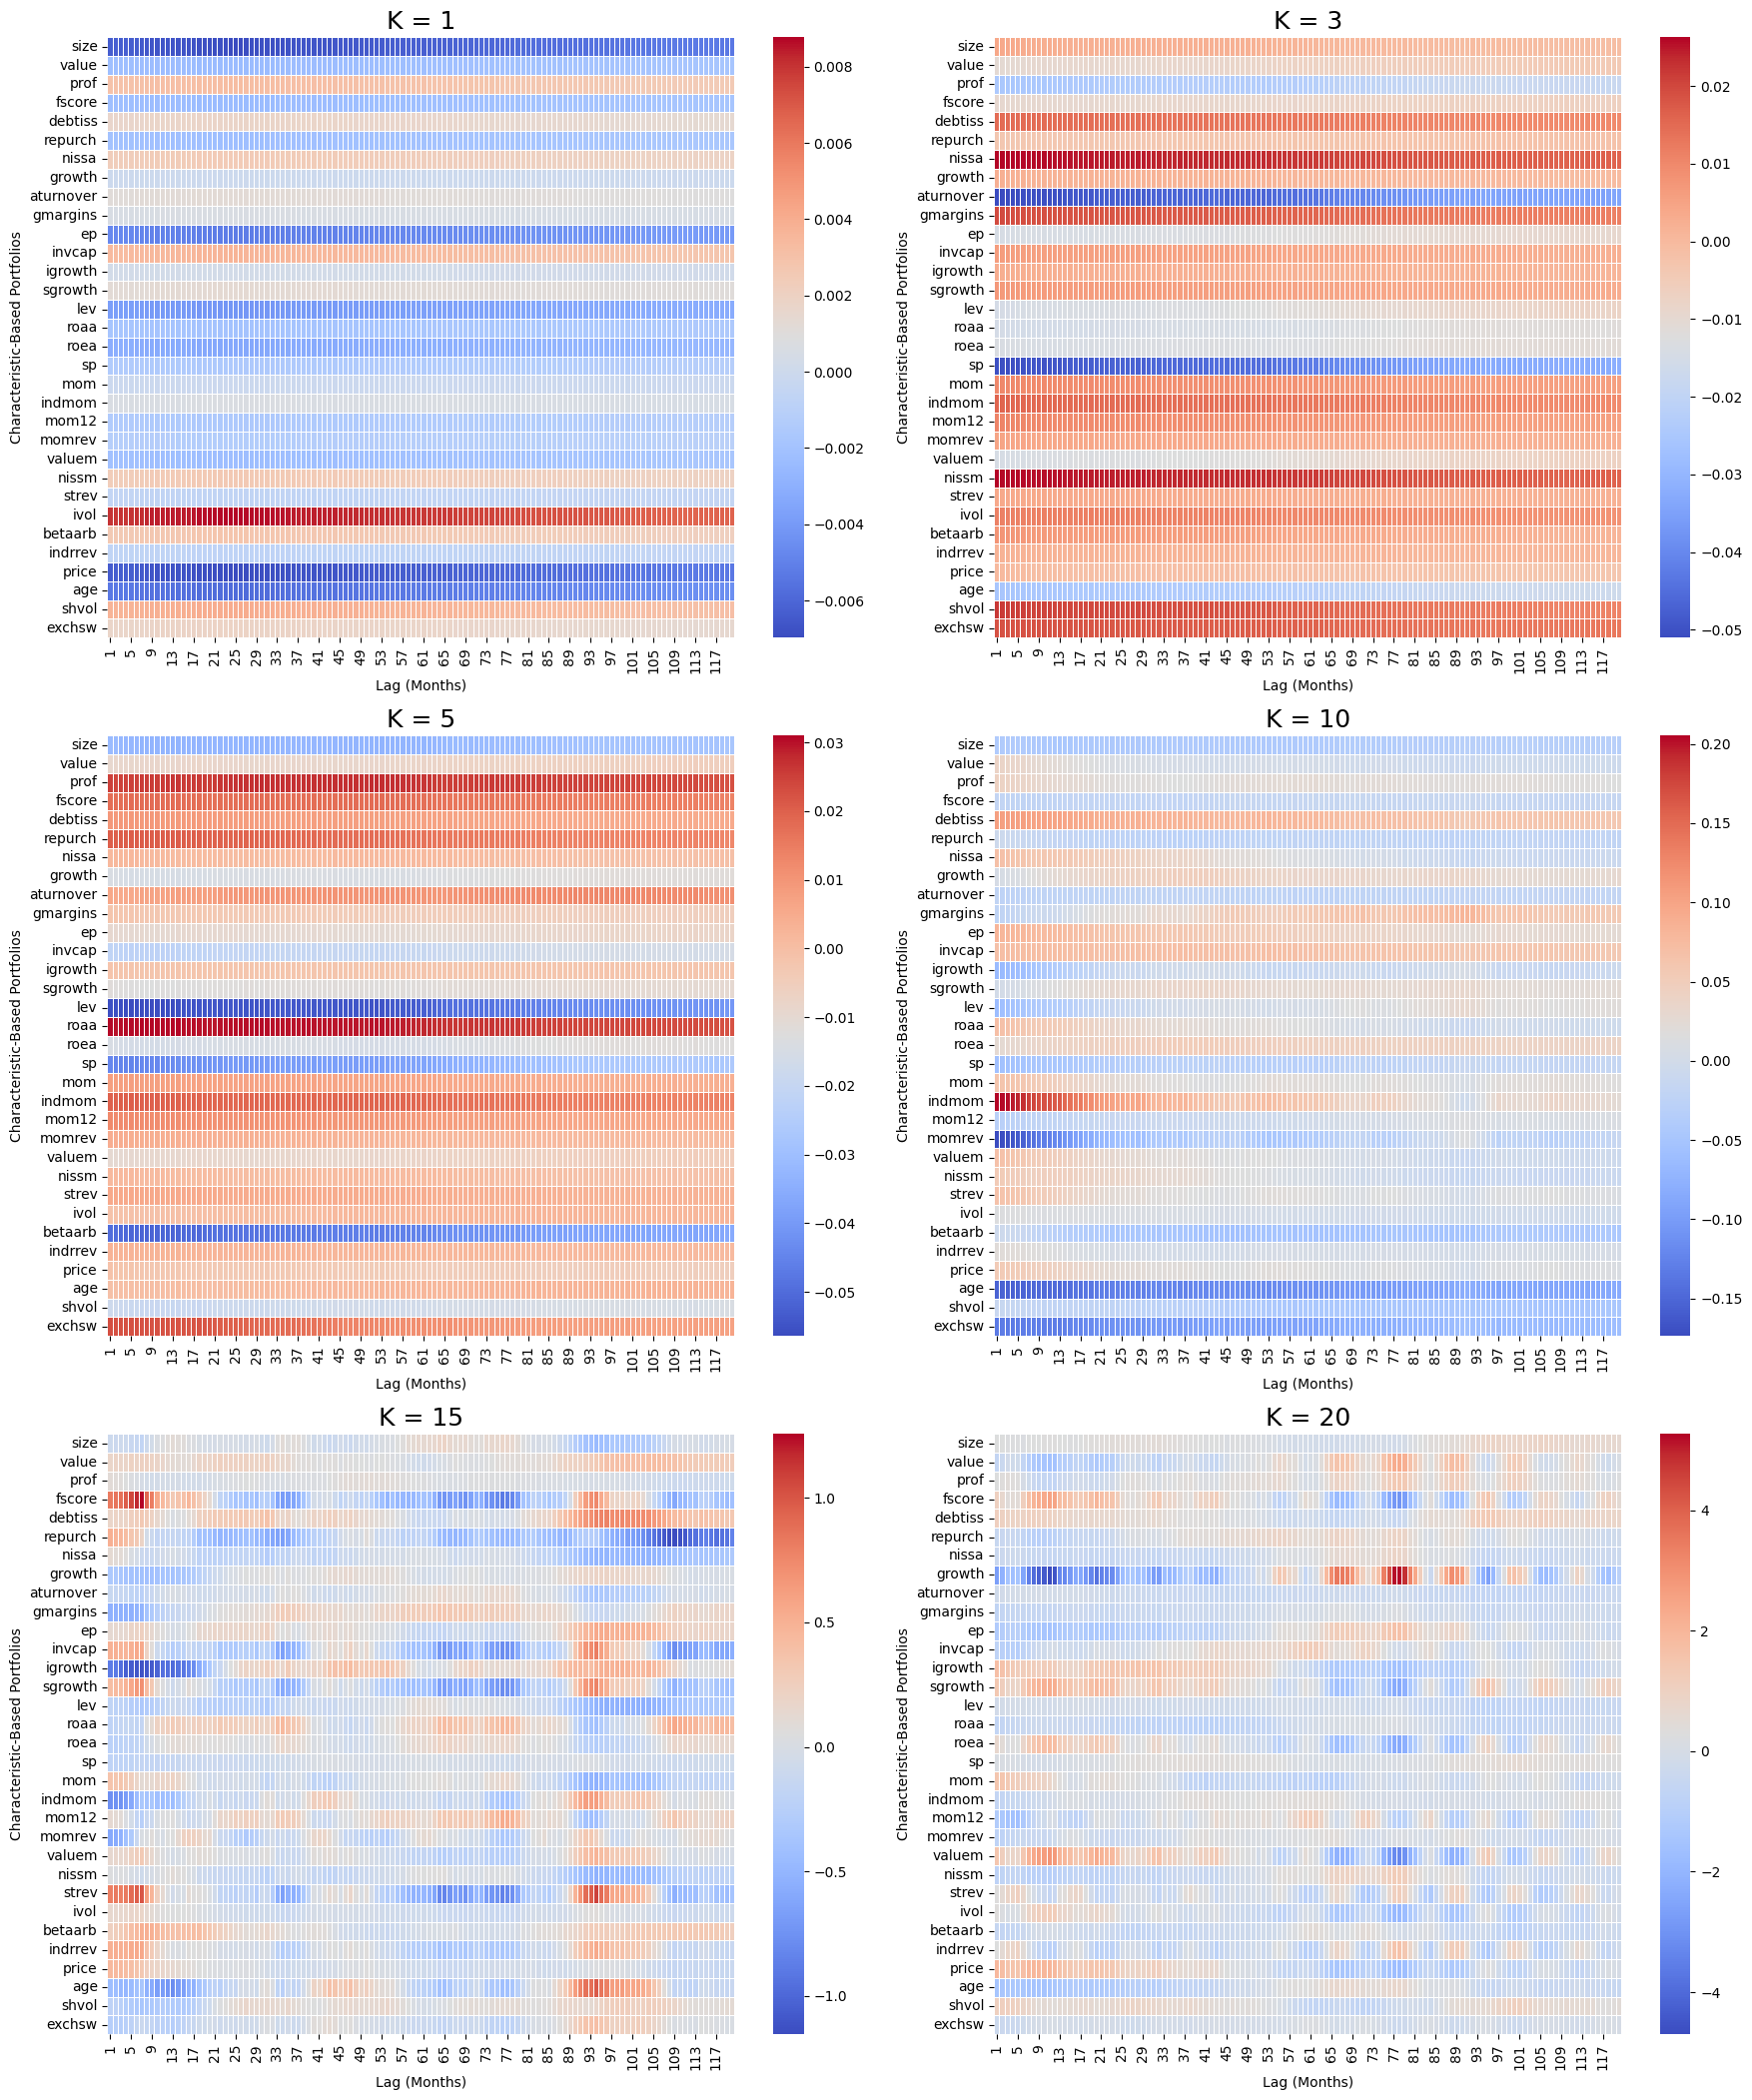

In [2]:
normalization = False 

for lag in lst_lags:
    fig, axes = plt.subplots(3, 2, figsize=(18, 22))
    for idx, K in enumerate([1, 3, 5, 10, 15, 20]):
        if idx >= 6:
            break
        
        weights, factors = parafac_enhanced(
            tensor=X_log[100: 220, :lag, :],
            rank=K,
            random_state=random_seed,
            n_iter_max=n_iter_max,
            fix_intercept_mode=1,
        )

        # Extract and normalize factors
        factors = dict(zip(['F','W','B'], factors))
        factors['S'] = weights
        factors = normalize_factors(factors, reorder=True)
        F, W, B, S = [factors[key] for key in ['F','W','B','S']]

        BS = B * S

        W_B = W @ jnp.linalg.inv(BS.T @ BS) @ BS.T # dim: (L, num_ptf)
        if normalization:
            W_B = W_B / jnp.linalg.norm(W_B, axis=0)  # Normalize each characteristic
        
        ax = axes[idx // 2, idx % 2]
        sns.heatmap(W_B.T, cmap='coolwarm', annot=False, fmt=".2f", linewidths=0.5, 
                    yticklabels=bin_labels, ax=ax)
        
        ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)  # Make yticklabels smalle
        xticks = ax.get_xticks()  # Get tick positions
        ax.set_xticklabels([int(tick) + 1 for tick in xticks])
        ax.set_xlabel("Lag (Months)")
        ax.set_ylabel("Characteristic-Based Portfolios")
        ax.set_title(f'K = {K}', fontsize=18)

    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit main title
    # plt.savefig(f"../interpretability/figures/WB_{lag}_{'norm' if normalization else 'unnorm'}")
    plt.show()